# Super Mario

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/06-deep-reinforcement-learning/06-super-mario.ipynb)

Let's build an agent that can make it through the first level of [Super Mario Bros (NES)](https://pypi.org/project/gym-super-mario-bros/). We will be using the **gym-super-mario-bros library**, built on top of OpenAI Gym and the [nes-py emulator](https://github.com/Kautenja/nes-py).

1. [Setup the environment](#Setup-the-environment)
2. [Setup the agent](#Setup-the-agent)
3. [Training the agent](#Training-the-agent)
4. [Exploit the policy](#Exploit-the-policy)


## Setup the environment

Below is the code snippet to download the environment:

In [54]:
!pip install gym-super-mario-bros > /dev/null 2>&1

We can instantieate it and view the size of each state, as well as the action space:

In [1]:
import gym
import gym_super_mario_bros

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')

# Dimensions of a frame
print('Frame: ', env.observation_space.shape)  

# Number of actions our agent can take
print('Actions: ', env.action_space.n)  

Frame:  (240, 256, 3)
Actions:  256


We can see that the observation space shape is 240 (widht) × 256 (height) × 3 (color channels) and the agent can take 256 different possible actions. In RL reducing the state and action space sizes speeds up convergence of models. A useful feature of Gym is that we can use the **Wrapper class** to change the default settings. Below we define a few classes to reduce frame size, to grayscale and to reduce the numbero of possible actions.

The first wrapper return just every skip frames and return the maximum value:

In [2]:
import collections 

class MaxAndSkip(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkip, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

The following wrapper downsamples and grayscales images to 84x84, finally it returns numpy array:

In [3]:
!pip install opencv-python > /dev/null 2>&1

In [4]:
import cv2

class Resizer(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(Resizer, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return Resizer.process(obs)

    @staticmethod
    def process(frame):
        img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

We need to convert each frame to a PyTorch tensor:

In [5]:
class Converter(gym.ObservationWrapper):
    def __init__(self, env):
        super(Converter, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

Only every fourth frame is collected by the buffer:

In [6]:
import numpy as np

class Buffer(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(Buffer, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0), old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

The frames are normalized so that pixel values are between 0 and 1:

In [7]:
class Scaler(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

We can create the enviroment and apply all the different transformations:

In [8]:
env = MaxAndSkip(env)
env = Resizer(env)
env = Converter(env)
env = Buffer(env, 4)
env = Scaler(env)

Finally, we can apply also a wrapper available for the nes_py simulator, calles JoypadSpace, in order to reduce the number of possible actions, see [this](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py)

In [9]:
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

env = JoypadSpace(env, COMPLEX_MOVEMENT)
#env = JoypadSpace(env, RIGHT_ONLY)

In [10]:
# Dimensions of a frame
print('Frame: ', env.observation_space.shape)  

# Number of actions our agent can take
print('Actions: ', env.action_space.n)  

Frame:  (4, 84, 84)
Actions:  12


Finally, we can show the environement selecting random actions:

In [11]:
import os 
import matplotlib.pyplot as plt
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

def show_environment(env, steps=100):
    plt.axis('off')
    observation = env.reset()
    done = False
    for _ in range(steps): 
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done: 
            observation = env.reset()
        clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array') )
        plt.show()   
    return

In [13]:
env.seed(200)
show_environment(env, steps=100)

KeyboardInterrupt: 

## Setup the agent

From the way we've set up our environment, a state is a list of 4 contiguous 84×84 pixel frames, and we have 5 possible actions. If we were to make a Q-table for this environment, the table would have $5×256^{84×84×4}$ values, since there are 5 possible actions for each state, each pixel has intensities between 0 and 255, and there are 84×84×4 pixels in a state. Clearly, storing a Q-table that large is impossible, so we have to resort to function approximation in which we use a neural network to approximate the Q-table.

### Function approximator

We use a convolutional neural net (which is ideal for image-based regression) with three convolutional layers and two linear layers. It takes two arguments: input_shape and output_dim. Of course, the input shape we will provide is 4×84×84, and there are 5 actions. 

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    
    def __init__(self, input_shape, n_actions):
        super(FCQ, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
                                  nn.ReLU(),
                                  nn.Conv2d(32, 64, kernel_size=4, stride=2),
                                  nn.ReLU(), 
                                  nn.Conv2d(64, 64, kernel_size=3, stride=1),
                                  nn.ReLU())

        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(nn.Linear(conv_out_size, 512), 
                                nn.ReLU(), 
                                nn.Linear(512, n_actions))
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### Replay Memory

In typical supervised learning, the neural network uses batches of data to update its weights. In deep Q-learning the idea is the same, except these batches of data are called batches of experiences, where an experience is a (state, action, reward, next_state, terminal) tuple. Instead of throwing away experiences, we can store them in a buffer to use later: the agent just has to sample a batch of experiences and use the double Q-update equation to update the network weights.

In [68]:
import numpy as np

class ReplayMemory():
    def __init__(self, state_space, max_size=10000, batch_size=64): 
        self.state_space = state_space
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
        
        self.states = torch.zeros(max_size, *self.state_space)
        self.actions = torch.zeros(max_size, 1)
        self.rewards = torch.zeros(max_size, 1)
        self.next_states = torch.zeros(max_size, *self.state_space)
        self.dones = torch.zeros(max_size, 1)

    def remember(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.Tensor(np.array([state])).float()
        self.actions[self.idx] = torch.tensor(np.array([action])).unsqueeze(0).float()
        self.rewards[self.idx] = torch.tensor(np.array([reward])).unsqueeze(0).float()
        self.next_states[self.idx] = torch.Tensor(np.array([next_state])).float()
        self.dones[self.idx] = torch.tensor(np.array([int(done)])).unsqueeze(0).float()
        self.idx += 1
        self.idx = self.idx % self.max_size
        self.size += 1
        self.size = min(self.size, self.max_size)

    def recall(self):
        idxs = np.random.choice(self.size, self.batch_size, replace=False)
        states = self.states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        next_states = self.next_states[idxs]
        dones = self.dones[idxs]
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return self.size

### Exploration and evaluation strategies

We need to decide how to balance the exploration-exploitation trade-off, almost any technique would work fine. To keep things simple, we’re going to use an exponentially decaying epsilon-greedy exploration strategy. However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [69]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action


In [70]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

### DDQN

As Rl algorithm we apply the Double Deep Q-Network, that utilises Double Q-learning to reduce overestimation of DQN by decomposing the max operation in the target into action selection and action evaluation. We evaluate the greedy policy according to the online network, but we use the target network to estimate its value.

In [71]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim
from tqdm import tqdm

class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, gamma, n_warmup_batches, target_update_steps):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.gamma = gamma
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

    def interaction_step(self, state):
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        self.replay_memory.remember(state, action, reward, new_state, is_terminal)
        self.episode_rewards[-1] += reward
        return new_state, is_terminal
    
    def optimize_model(self):
        if len(self.replay_memory) < self.replay_memory.batch_size * self.n_warmup_batches:
            return
        states, actions, rewards, next_states, is_terminals = self.replay_memory.recall()
        max_a_q = self.target_model(next_states).max(1).values.unsqueeze(1)
        target = rewards + torch.mul(self.gamma * max_a_q, (1 - is_terminals))
        current = self.online_model(states).gather(1, actions.long())
        td_error = current - target
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, max_episodes):
        self.episode_rewards = []      
        results = np.empty(max_episodes)
        self.update_network()
        for episode in tqdm(range(1, max_episodes + 1), leave=True):                 
            episode_steps = 0;
            self.episode_rewards.append(0.0)
            state = self.env.reset()
            is_terminal = False
            for step in count():
                state, is_terminal = self.interaction_step(state)
                self.optimize_model()
                if episode_steps % self.target_update_steps == 0:
                    self.update_network()
                episode_steps += 1
                if is_terminal: break
            mean_reward = np.mean(self.episode_rewards[-10:])
            std_reward = np.std(self.episode_rewards[-10:])
            results[episode-1] = mean_reward
            debug_message = 'episode {:04}, score {:05.1f} ({:05.1f})'
            debug_message = debug_message.format(episode-1, mean_reward, std_reward)
            print(debug_message, end='\r', flush=True)
            training_is_over = episode >= max_episodes
            if training_is_over:
                break
        return results
    
    def evaluate(self, n_episodes=10):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for step in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    

## Training the agent

In [79]:
gamma = 0.90
learning_rate = 0.0005
max_episodes = 1500

memory_size = 5000
batch_size = 64
n_warmup_batches = 3

target_update_steps = 25
seed = 7

space, actions = env.observation_space.shape, env.action_space.n
    
print('Training started...')
    
online_model = FCQ(space, actions)
target_model = FCQ(space, actions)
optimizer = optim.RMSprop(online_model.parameters(), lr=learning_rate)
replay_memory = ReplayMemory(state_space=space, max_size=memory_size, batch_size=batch_size)  
train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.4, decay_steps=200000)
eval_strategy = GreedyStrategy()
        
agent = DDQN(env, online_model, target_model, optimizer, 
             train_strategy, eval_strategy, replay_memory, seed,
             gamma, n_warmup_batches, target_update_steps)

results = agent.train(max_episodes)

print('...training complete')   

Training started...


  0%|                                                  | 0/1500 [00:00<?, ?it/s]

  0%|                                          | 1/1500 [00:01<29:19,  1.17s/it]

  0%|                                      | 2/1500 [04:20<63:44:33, 153.19s/it]

  0%|                                      | 3/1500 [08:53<86:28:03, 207.94s/it]

  0%|                                      | 4/1500 [11:25<77:07:18, 185.59s/it]

  0%|▏                                     | 5/1500 [15:46<88:28:58, 213.07s/it]

  0%|▏                                     | 6/1500 [20:08<95:19:21, 229.69s/it]

  0%|▏                                     | 7/1500 [24:30<99:35:34, 240.14s/it]

  1%|▏                                    | 8/1500 [28:53<102:29:23, 247.29s/it]

  1%|▏                                     | 9/1500 [29:03<71:41:20, 173.09s/it]

  1%|▏                                    | 10/1500 [29:13<50:54:12, 122.99s/it]

  1%|▎                                    | 11/1500 [30:14<43:01:07, 104.01s/it]

  1%|▎                                    | 12/1500 [34:37<62:54:38, 152.20s/it]

  1%|▎                                    | 13/1500 [39:01<76:50:01, 186.01s/it]

  1%|▎                                    | 14/1500 [43:23<86:16:48, 209.02s/it]

  1%|▎                                    | 15/1500 [47:45<92:52:29, 225.15s/it]

  1%|▍                                    | 16/1500 [48:09<67:50:09, 164.56s/it]

  1%|▍                                    | 17/1500 [48:22<48:57:18, 118.84s/it]

  1%|▍                                    | 18/1500 [52:45<66:49:58, 162.35s/it]

  1%|▍                                    | 19/1500 [52:55<47:53:17, 116.41s/it]

  1%|▌                                     | 20/1500 [53:01<34:16:43, 83.38s/it]

  1%|▌                                     | 21/1500 [53:11<25:12:41, 61.37s/it]

  1%|▌                                     | 22/1500 [56:18<40:35:11, 98.86s/it]

  2%|▌                                     | 23/1500 [57:10<34:52:56, 85.02s/it]

  2%|▌                                     | 24/1500 [57:27<26:29:53, 64.63s/it]

  2%|▋                                     | 25/1500 [59:43<35:13:23, 85.97s/it]

  2%|▌                                  | 26/1500 [1:02:42<46:38:55, 113.93s/it]

  2%|▋                                   | 27/1500 [1:03:04<35:17:02, 86.23s/it]

  2%|▋                                  | 28/1500 [1:07:27<56:57:17, 139.29s/it]

  2%|▋                                  | 29/1500 [1:11:50<72:05:31, 176.43s/it]

  2%|▋                                  | 30/1500 [1:12:01<51:43:20, 126.67s/it]

  2%|▋                                   | 31/1500 [1:12:07<37:00:11, 90.68s/it]

  2%|▋                                  | 32/1500 [1:14:48<45:32:58, 111.70s/it]

  2%|▊                                   | 33/1500 [1:15:01<33:25:15, 82.01s/it]

  2%|▊                                   | 34/1500 [1:15:16<25:17:45, 62.12s/it]

  2%|▊                                   | 35/1500 [1:18:25<40:39:08, 99.90s/it]

  2%|▊                                  | 36/1500 [1:23:09<63:11:37, 155.39s/it]

  2%|▊                                  | 37/1500 [1:23:56<49:51:42, 122.69s/it]

  3%|▉                                  | 38/1500 [1:28:46<70:16:14, 173.03s/it]

  3%|▉                                  | 39/1500 [1:29:02<51:01:55, 125.75s/it]

  3%|▉                                  | 40/1500 [1:29:55<42:10:52, 104.01s/it]

  3%|▉                                  | 41/1500 [1:35:03<66:54:14, 165.08s/it]

  3%|▉                                  | 42/1500 [1:36:25<56:49:43, 140.32s/it]

  3%|█                                  | 43/1500 [1:41:16<75:04:08, 185.48s/it]

  3%|█                                  | 44/1500 [1:41:23<53:20:02, 131.87s/it]

  3%|█                                   | 45/1500 [1:41:36<38:55:59, 96.33s/it]

  3%|█                                  | 46/1500 [1:46:27<62:25:50, 154.57s/it]

  3%|█                                  | 47/1500 [1:46:37<44:57:09, 111.38s/it]

  3%|█                                  | 48/1500 [1:48:52<47:44:45, 118.38s/it]

  3%|█▏                                  | 49/1500 [1:49:03<34:47:24, 86.32s/it]

  3%|█▏                                 | 50/1500 [1:53:57<59:45:41, 148.37s/it]

  3%|█▏                                 | 51/1500 [1:54:16<44:09:31, 109.71s/it]

  3%|█▏                                 | 52/1500 [1:56:14<45:04:10, 112.05s/it]

  4%|█▏                                 | 53/1500 [1:57:31<40:48:13, 101.52s/it]

  4%|█▎                                 | 54/1500 [2:02:30<64:40:47, 161.03s/it]

  4%|█▎                                 | 55/1500 [2:07:30<81:15:48, 202.46s/it]

  4%|█▎                                 | 56/1500 [2:07:34<57:24:25, 143.12s/it]

  4%|█▎                                 | 57/1500 [2:07:52<42:15:35, 105.43s/it]

  4%|█▍                                  | 58/1500 [2:08:04<31:01:59, 77.48s/it]

  4%|█▍                                  | 59/1500 [2:09:29<31:52:59, 79.65s/it]

  4%|█▍                                  | 60/1500 [2:09:48<24:37:42, 61.57s/it]

  4%|█▍                                  | 61/1500 [2:12:55<39:36:16, 99.08s/it]

  4%|█▍                                 | 62/1500 [2:17:23<59:51:31, 149.86s/it]

  4%|█▍                                 | 63/1500 [2:18:55<52:54:37, 132.55s/it]

  4%|█▍                                 | 64/1500 [2:21:08<52:56:07, 132.71s/it]

  4%|█▌                                 | 65/1500 [2:23:10<51:37:07, 129.50s/it]

  4%|█▌                                 | 66/1500 [2:24:40<46:49:39, 117.56s/it]

  4%|█▌                                 | 67/1500 [2:29:35<68:00:27, 170.85s/it]

  5%|█▌                                 | 68/1500 [2:30:34<54:33:39, 137.16s/it]

  5%|█▌                                 | 69/1500 [2:32:31<52:08:36, 131.18s/it]

  5%|█▋                                  | 70/1500 [2:32:57<39:31:28, 99.50s/it]

  5%|█▋                                 | 71/1500 [2:35:47<47:54:56, 120.71s/it]

  5%|█▋                                 | 72/1500 [2:37:01<42:23:43, 106.88s/it]

  5%|█▊                                  | 73/1500 [2:37:14<31:06:12, 78.47s/it]

  5%|█▊                                  | 74/1500 [2:37:23<22:54:31, 57.83s/it]

  5%|█▊                                  | 75/1500 [2:38:14<22:06:16, 55.84s/it]

  5%|█▊                                  | 76/1500 [2:38:53<20:06:08, 50.82s/it]

  5%|█▊                                 | 77/1500 [2:42:52<42:19:03, 107.06s/it]

  5%|█▊                                  | 78/1500 [2:43:00<30:36:28, 77.49s/it]

  5%|█▊                                 | 79/1500 [2:47:59<56:44:32, 143.75s/it]

  5%|█▊                                 | 80/1500 [2:48:31<43:32:03, 110.37s/it]

  5%|█▉                                  | 81/1500 [2:48:39<31:24:46, 79.69s/it]

  5%|█▉                                 | 82/1500 [2:53:25<55:42:21, 141.43s/it]

  6%|█▉                                 | 83/1500 [2:54:08<44:03:55, 111.95s/it]

  6%|█▉                                 | 84/1500 [2:56:17<46:04:20, 117.13s/it]

  6%|█▉                                 | 85/1500 [2:57:48<42:56:56, 109.27s/it]

  6%|██                                 | 86/1500 [2:59:25<41:31:15, 105.71s/it]

  6%|██                                 | 87/1500 [3:02:33<51:07:20, 130.25s/it]

  6%|██                                 | 88/1500 [3:03:33<42:47:11, 109.09s/it]

  6%|██▏                                 | 89/1500 [3:03:42<31:02:56, 79.22s/it]

  6%|██▏                                 | 90/1500 [3:04:58<30:36:49, 78.16s/it]

  6%|██▏                                 | 91/1500 [3:06:33<32:35:35, 83.28s/it]

  6%|██▏                                | 92/1500 [3:11:28<57:23:42, 146.75s/it]

  6%|██▏                                | 93/1500 [3:13:14<52:37:14, 134.64s/it]

  6%|██▏                                | 94/1500 [3:15:03<49:29:35, 126.73s/it]

  6%|██▏                                | 95/1500 [3:20:03<69:44:24, 178.69s/it]

  6%|██▏                                | 96/1500 [3:25:00<83:34:47, 214.31s/it]

  6%|██▎                                | 97/1500 [3:27:22<75:03:10, 192.58s/it]

  7%|██▎                                | 98/1500 [3:28:45<62:11:27, 159.69s/it]

  7%|██▎                                | 99/1500 [3:28:54<44:34:21, 114.53s/it]

  7%|██▎                               | 100/1500 [3:30:15<40:38:06, 104.49s/it]

  7%|██▎                                | 101/1500 [3:30:27<29:50:49, 76.80s/it]

  7%|██▍                                | 102/1500 [3:31:06<25:23:59, 65.41s/it]

  7%|██▎                               | 103/1500 [3:34:12<39:27:21, 101.68s/it]

  7%|██▍                                | 104/1500 [3:34:55<32:33:24, 83.96s/it]

  7%|██▍                                | 105/1500 [3:35:02<23:33:30, 60.80s/it]

  7%|██▍                                | 106/1500 [3:35:47<21:47:34, 56.28s/it]

  7%|██▍                               | 107/1500 [3:39:53<43:46:23, 113.13s/it]

  7%|██▍                               | 108/1500 [3:42:05<45:51:18, 118.59s/it]

  7%|██▌                                | 109/1500 [3:42:16<33:26:50, 86.56s/it]

  7%|██▌                                | 110/1500 [3:42:26<24:27:58, 63.37s/it]

  7%|██▌                               | 111/1500 [3:46:14<43:35:23, 112.98s/it]

  7%|██▌                                | 112/1500 [3:46:30<32:20:59, 83.90s/it]

  8%|██▌                               | 113/1500 [3:50:23<49:33:12, 128.62s/it]

  8%|██▋                                | 114/1500 [3:50:32<35:37:20, 92.53s/it]

  8%|██▌                               | 115/1500 [3:53:11<43:18:09, 112.56s/it]

  8%|██▋                                | 116/1500 [3:53:55<35:21:56, 91.99s/it]

  8%|██▋                               | 117/1500 [3:56:55<45:30:21, 118.45s/it]

  8%|██▊                                | 118/1500 [3:57:05<32:59:50, 85.96s/it]

  8%|██▊                                | 119/1500 [3:58:42<34:10:10, 89.07s/it]

  8%|██▊                                | 120/1500 [3:58:50<24:51:43, 64.86s/it]

  8%|██▋                               | 121/1500 [4:02:10<40:22:48, 105.42s/it]

  8%|██▊                                | 122/1500 [4:02:16<28:52:43, 75.45s/it]

  8%|██▊                               | 123/1500 [4:05:57<45:37:52, 119.30s/it]

  8%|██▉                                | 124/1500 [4:06:04<32:39:22, 85.44s/it]

  8%|██▊                               | 125/1500 [4:09:37<47:15:34, 123.73s/it]

  8%|██▉                                | 126/1500 [4:09:49<34:27:24, 90.28s/it]

  8%|██▉                                | 127/1500 [4:10:03<25:43:12, 67.44s/it]

  9%|██▉                                | 128/1500 [4:12:26<34:19:11, 90.05s/it]

  9%|███                                | 129/1500 [4:13:20<30:12:54, 79.34s/it]

  9%|███                                | 130/1500 [4:14:40<30:14:06, 79.45s/it]

  9%|███                                | 131/1500 [4:15:47<28:49:02, 75.78s/it]

  9%|███                                | 132/1500 [4:17:22<30:58:39, 81.52s/it]

  9%|███                                | 133/1500 [4:18:12<27:20:32, 72.01s/it]

  9%|███▏                               | 134/1500 [4:20:35<35:26:49, 93.42s/it]

  9%|███▏                               | 135/1500 [4:21:01<27:42:38, 73.08s/it]

  9%|███▏                               | 136/1500 [4:22:19<28:14:33, 74.54s/it]

  9%|███▏                               | 137/1500 [4:22:30<21:01:00, 55.51s/it]

  9%|███▏                               | 138/1500 [4:22:36<15:23:58, 40.70s/it]

  9%|███▏                               | 139/1500 [4:22:55<12:56:07, 34.22s/it]

  9%|███▎                               | 140/1500 [4:23:06<10:19:00, 27.31s/it]

  9%|███▎                               | 141/1500 [4:24:35<17:12:32, 45.59s/it]

  9%|███▎                               | 142/1500 [4:26:04<22:10:50, 58.80s/it]

 10%|███▎                               | 143/1500 [4:27:48<27:14:01, 72.25s/it]

 10%|███▎                               | 144/1500 [4:27:54<19:42:32, 52.33s/it]

 10%|███▍                               | 145/1500 [4:28:44<19:26:41, 51.66s/it]

 10%|███▍                               | 146/1500 [4:29:00<15:23:29, 40.92s/it]

 10%|███▍                               | 147/1500 [4:31:19<26:31:49, 70.59s/it]

 10%|███▍                               | 148/1500 [4:32:42<27:53:11, 74.25s/it]

 10%|███▍                               | 149/1500 [4:33:01<21:36:53, 57.60s/it]

 10%|███▌                               | 150/1500 [4:34:09<22:45:31, 60.69s/it]

 10%|███▌                               | 151/1500 [4:34:16<16:40:25, 44.50s/it]

 10%|███▍                              | 152/1500 [4:39:17<45:27:44, 121.41s/it]

 10%|███▌                               | 153/1500 [4:39:24<32:38:59, 87.26s/it]

 10%|███▌                               | 154/1500 [4:39:59<26:42:44, 71.44s/it]

 10%|███▌                               | 155/1500 [4:40:28<21:56:51, 58.74s/it]

 10%|███▋                               | 156/1500 [4:40:35<16:09:56, 43.30s/it]

 10%|███▋                               | 157/1500 [4:40:44<12:18:57, 33.01s/it]

 11%|███▋                               | 158/1500 [4:43:45<28:52:37, 77.46s/it]

 11%|███▋                               | 159/1500 [4:43:59<21:41:58, 58.25s/it]

 11%|███▋                               | 160/1500 [4:44:11<16:33:21, 44.48s/it]

 11%|███▊                               | 161/1500 [4:45:06<17:44:58, 47.72s/it]

 11%|███▊                               | 162/1500 [4:45:16<13:31:42, 36.40s/it]

 11%|███▊                               | 163/1500 [4:45:27<10:36:34, 28.57s/it]

 11%|███▉                                | 164/1500 [4:45:31<7:53:06, 21.25s/it]

 11%|███▊                               | 165/1500 [4:49:57<35:10:21, 94.85s/it]

 11%|███▊                               | 166/1500 [4:51:07<32:24:28, 87.46s/it]

 11%|███▉                               | 167/1500 [4:51:14<23:25:45, 63.27s/it]

 11%|███▉                               | 168/1500 [4:51:22<17:17:33, 46.74s/it]

 11%|███▉                               | 169/1500 [4:52:52<21:58:53, 59.45s/it]

 11%|███▉                               | 170/1500 [4:53:38<20:31:14, 55.54s/it]

 11%|███▉                               | 171/1500 [4:53:47<15:19:40, 41.52s/it]

 11%|████                               | 172/1500 [4:55:02<19:04:20, 51.70s/it]

 12%|████                               | 173/1500 [4:57:23<28:53:58, 78.40s/it]

 12%|████                               | 174/1500 [4:57:28<20:47:40, 56.46s/it]

 12%|████                               | 175/1500 [4:57:37<15:31:32, 42.18s/it]

 12%|████                               | 176/1500 [4:57:41<11:18:57, 30.77s/it]

 12%|████▏                               | 177/1500 [4:57:51<8:59:44, 24.48s/it]

 12%|████▏                              | 178/1500 [4:58:28<10:20:30, 28.16s/it]

 12%|████▎                               | 179/1500 [4:58:35<7:58:34, 21.74s/it]

 12%|████▏                              | 180/1500 [5:03:12<36:04:04, 98.37s/it]

 12%|████▏                              | 181/1500 [5:04:13<31:58:55, 87.29s/it]

 12%|████▏                              | 182/1500 [5:04:25<23:38:43, 64.59s/it]

 12%|████▎                              | 183/1500 [5:04:35<17:39:11, 48.25s/it]

 12%|████▎                              | 184/1500 [5:04:57<14:48:13, 40.50s/it]

 12%|████▎                              | 185/1500 [5:07:59<30:12:38, 82.71s/it]

 12%|████▎                              | 186/1500 [5:08:04<21:42:03, 59.45s/it]

 12%|████▎                              | 187/1500 [5:08:26<17:33:51, 48.16s/it]

 13%|████▍                              | 188/1500 [5:08:33<13:03:03, 35.81s/it]

 13%|████▍                              | 189/1500 [5:09:48<17:25:13, 47.84s/it]

 13%|████▍                              | 190/1500 [5:10:12<14:48:02, 40.67s/it]

 13%|████▍                              | 191/1500 [5:10:19<11:04:37, 30.46s/it]

 13%|████▌                               | 192/1500 [5:10:30<8:58:29, 24.70s/it]

 13%|████▌                              | 193/1500 [5:11:10<10:38:40, 29.32s/it]

 13%|████▌                              | 194/1500 [5:13:26<22:11:50, 61.19s/it]

 13%|████▌                              | 195/1500 [5:16:19<34:18:18, 94.63s/it]

 13%|████▌                              | 196/1500 [5:16:26<24:50:32, 68.58s/it]

 13%|████▌                              | 197/1500 [5:16:43<19:12:13, 53.06s/it]

 13%|████▌                              | 198/1500 [5:19:57<34:24:38, 95.14s/it]

 13%|████▋                              | 199/1500 [5:20:13<25:50:00, 71.48s/it]

 13%|████▋                              | 200/1500 [5:20:45<21:30:10, 59.55s/it]

 13%|████▋                              | 201/1500 [5:21:51<22:14:30, 61.64s/it]

 13%|████▋                              | 202/1500 [5:22:18<18:29:02, 51.27s/it]

 14%|████▋                              | 203/1500 [5:22:25<13:37:54, 37.84s/it]

 14%|████▊                              | 204/1500 [5:22:31<10:13:12, 28.39s/it]

 14%|████▉                               | 205/1500 [5:22:46<8:47:26, 24.44s/it]

 14%|████▊                              | 206/1500 [5:25:55<26:27:47, 73.62s/it]

 14%|████▊                              | 207/1500 [5:26:02<19:16:43, 53.68s/it]

 14%|████▊                              | 208/1500 [5:26:10<14:21:22, 40.00s/it]

 14%|████▉                              | 209/1500 [5:26:16<10:45:22, 29.99s/it]

 14%|█████                               | 210/1500 [5:26:24<8:20:29, 23.28s/it]

 14%|████▉                              | 211/1500 [5:30:28<32:00:33, 89.40s/it]

 14%|████▉                              | 212/1500 [5:31:53<31:32:26, 88.16s/it]

 14%|████▉                              | 213/1500 [5:32:03<23:08:48, 64.75s/it]

 14%|████▉                              | 214/1500 [5:32:29<18:55:05, 52.96s/it]

 14%|█████                              | 215/1500 [5:32:35<13:57:43, 39.12s/it]

 14%|█████                              | 216/1500 [5:32:43<10:38:01, 29.81s/it]

 14%|█████                              | 217/1500 [5:34:56<21:36:11, 60.62s/it]

 15%|█████                              | 218/1500 [5:36:14<23:27:40, 65.88s/it]

 15%|█████                              | 219/1500 [5:38:19<29:41:50, 83.46s/it]

 15%|█████▏                             | 220/1500 [5:38:29<21:50:50, 61.45s/it]

 15%|█████▏                             | 221/1500 [5:38:36<16:05:18, 45.28s/it]

 15%|█████▏                             | 222/1500 [5:38:56<13:21:23, 37.62s/it]

 15%|█████▎                              | 223/1500 [5:39:02<9:58:24, 28.12s/it]

 15%|█████▍                              | 224/1500 [5:39:14<8:13:06, 23.19s/it]

 15%|█████▎                             | 225/1500 [5:40:15<12:17:15, 34.69s/it]

 15%|█████▎                             | 226/1500 [5:42:14<21:11:23, 59.88s/it]

 15%|█████▎                             | 227/1500 [5:44:10<27:06:29, 76.66s/it]

 15%|█████▎                             | 228/1500 [5:45:54<30:03:01, 85.05s/it]

 15%|█████▎                             | 229/1500 [5:46:21<23:48:06, 67.42s/it]

 15%|█████▎                             | 230/1500 [5:48:04<27:35:20, 78.20s/it]

 15%|█████▍                             | 231/1500 [5:48:21<21:04:00, 59.76s/it]

 15%|█████▍                             | 232/1500 [5:49:19<20:52:56, 59.29s/it]

 16%|█████▍                             | 233/1500 [5:50:23<21:25:49, 60.89s/it]

 16%|█████▍                             | 234/1500 [5:51:02<19:03:56, 54.22s/it]

 16%|█████▍                             | 235/1500 [5:51:07<13:53:08, 39.52s/it]

 16%|█████▌                             | 236/1500 [5:52:37<19:12:07, 54.69s/it]

 16%|█████▌                             | 237/1500 [5:52:47<14:27:58, 41.23s/it]

 16%|█████▌                             | 238/1500 [5:54:26<20:28:15, 58.40s/it]

 16%|█████▌                             | 239/1500 [5:54:33<15:07:15, 43.17s/it]

 16%|█████▌                             | 240/1500 [5:55:12<14:37:35, 41.79s/it]

 16%|█████▌                             | 241/1500 [5:56:16<16:59:39, 48.59s/it]

 16%|█████▋                             | 242/1500 [5:56:35<13:52:59, 39.73s/it]

 16%|█████▋                             | 243/1500 [5:57:41<16:37:22, 47.61s/it]

 16%|█████▋                             | 244/1500 [5:57:50<12:30:21, 35.85s/it]

 16%|█████▉                              | 245/1500 [5:57:58<9:33:47, 27.43s/it]

 16%|█████▉                              | 246/1500 [5:58:08<7:46:37, 22.33s/it]

 16%|█████▌                            | 247/1500 [6:03:17<37:40:07, 108.23s/it]

 17%|█████▌                            | 248/1500 [6:05:05<37:39:17, 108.27s/it]

 17%|█████▊                             | 249/1500 [6:05:15<27:19:43, 78.64s/it]

 17%|█████▊                             | 250/1500 [6:06:40<28:03:42, 80.82s/it]

 17%|█████▊                             | 251/1500 [6:07:22<23:55:32, 68.96s/it]

 17%|█████▉                             | 252/1500 [6:07:28<17:25:40, 50.27s/it]

 17%|█████▉                             | 253/1500 [6:08:32<18:48:35, 54.30s/it]

 17%|█████▉                             | 254/1500 [6:09:15<17:34:15, 50.77s/it]

 17%|█████▉                             | 255/1500 [6:10:03<17:21:23, 50.19s/it]

 17%|█████▉                             | 256/1500 [6:10:38<15:44:35, 45.56s/it]

 17%|█████▉                             | 257/1500 [6:11:02<13:28:48, 39.04s/it]

 17%|██████                             | 258/1500 [6:11:32<12:30:15, 36.24s/it]

 17%|██████                             | 259/1500 [6:12:01<11:44:34, 34.06s/it]

 17%|██████                             | 260/1500 [6:13:00<14:18:44, 41.55s/it]

 17%|██████                             | 261/1500 [6:15:31<25:34:26, 74.31s/it]

 17%|██████                             | 262/1500 [6:15:38<18:37:22, 54.15s/it]

 18%|██████▏                            | 263/1500 [6:17:19<23:25:43, 68.18s/it]

 18%|██████▏                            | 264/1500 [6:18:35<24:18:02, 70.78s/it]

 18%|██████▏                            | 265/1500 [6:19:08<20:21:02, 59.32s/it]

 18%|██████▏                            | 266/1500 [6:19:19<15:21:51, 44.82s/it]

 18%|██████▏                            | 267/1500 [6:20:50<20:08:12, 58.79s/it]

 18%|██████▎                            | 268/1500 [6:21:59<21:07:27, 61.73s/it]

 18%|██████▎                            | 269/1500 [6:22:18<16:44:35, 48.96s/it]

 18%|██████▎                            | 270/1500 [6:22:28<12:45:44, 37.35s/it]

 18%|██████▎                            | 271/1500 [6:25:34<27:58:43, 81.96s/it]

 18%|██████▎                            | 272/1500 [6:25:40<20:09:56, 59.12s/it]

 18%|██████▎                            | 273/1500 [6:26:48<21:01:12, 61.67s/it]

 18%|██████▏                           | 274/1500 [6:31:59<46:28:08, 136.45s/it]

 18%|██████▏                           | 275/1500 [6:32:44<37:08:28, 109.15s/it]

 18%|██████▎                           | 276/1500 [6:34:20<35:44:37, 105.13s/it]

 18%|██████▍                            | 277/1500 [6:34:27<25:43:09, 75.71s/it]

 19%|██████▎                           | 278/1500 [6:38:03<40:00:23, 117.86s/it]

 19%|██████▌                            | 279/1500 [6:38:10<28:37:26, 84.39s/it]

 19%|██████▌                            | 280/1500 [6:38:18<20:54:36, 61.70s/it]

 19%|██████▌                            | 281/1500 [6:38:45<17:18:56, 51.14s/it]

 19%|██████▌                            | 282/1500 [6:38:52<12:50:02, 37.93s/it]

 19%|██████▌                            | 283/1500 [6:39:50<14:51:03, 43.93s/it]

 19%|██████▋                            | 284/1500 [6:40:05<11:52:59, 35.18s/it]

 19%|██████▋                            | 285/1500 [6:40:28<10:42:04, 31.71s/it]

 19%|██████▍                           | 286/1500 [6:45:10<35:59:09, 106.71s/it]

 19%|██████▋                            | 287/1500 [6:46:01<30:17:29, 89.90s/it]

 19%|██████▋                            | 288/1500 [6:46:11<22:11:59, 65.94s/it]

 19%|██████▋                            | 289/1500 [6:46:17<16:07:50, 47.95s/it]

 19%|██████▊                            | 290/1500 [6:46:27<12:20:15, 36.71s/it]

 19%|██████▊                            | 291/1500 [6:46:47<10:35:57, 31.56s/it]

 19%|███████                             | 292/1500 [6:46:54<8:06:28, 24.16s/it]

 20%|██████▊                            | 293/1500 [6:47:51<11:24:48, 34.04s/it]

 20%|███████                             | 294/1500 [6:47:58<8:44:46, 26.11s/it]

 20%|██████▉                            | 295/1500 [6:50:04<18:42:16, 55.88s/it]

 20%|██████▉                            | 296/1500 [6:50:12<13:54:51, 41.60s/it]

 20%|██████▉                            | 297/1500 [6:51:00<14:30:39, 43.42s/it]

 20%|██████▉                            | 298/1500 [6:53:06<22:45:44, 68.17s/it]

 20%|██████▉                            | 299/1500 [6:53:31<18:30:04, 55.46s/it]

 20%|███████                            | 300/1500 [6:55:42<26:00:30, 78.03s/it]

 20%|███████                            | 301/1500 [6:56:02<20:09:34, 60.53s/it]

 20%|███████                            | 302/1500 [6:56:28<16:42:07, 50.19s/it]

 20%|███████                            | 303/1500 [6:56:36<12:28:04, 37.50s/it]

 20%|███████                            | 304/1500 [6:58:03<17:25:53, 52.47s/it]

 20%|███████                            | 305/1500 [6:58:54<17:17:52, 52.11s/it]

 20%|███████▏                           | 306/1500 [6:59:08<13:29:34, 40.68s/it]

 20%|███████▏                           | 307/1500 [6:59:15<10:03:43, 30.36s/it]

 21%|███████▍                            | 308/1500 [6:59:22<7:45:34, 23.43s/it]

 21%|███████▍                            | 309/1500 [6:59:44<7:36:53, 23.02s/it]

 21%|███████▍                            | 310/1500 [7:00:07<7:35:27, 22.96s/it]

 21%|███████▍                            | 311/1500 [7:00:36<8:10:09, 24.73s/it]

 21%|███████▍                            | 312/1500 [7:00:49<7:01:40, 21.30s/it]

 21%|███████▌                            | 313/1500 [7:00:55<5:28:29, 16.60s/it]

 21%|███████▎                           | 314/1500 [7:03:58<21:56:57, 66.62s/it]

 21%|███████▎                           | 315/1500 [7:04:04<15:57:35, 48.49s/it]

 21%|███████▎                           | 316/1500 [7:05:05<17:12:00, 52.30s/it]

 21%|███████▍                           | 317/1500 [7:05:14<12:51:10, 39.11s/it]

 21%|███████▋                            | 318/1500 [7:05:23<9:55:43, 30.24s/it]

 21%|███████▋                            | 319/1500 [7:05:36<8:12:24, 25.02s/it]

 21%|███████▋                            | 320/1500 [7:05:41<6:14:48, 19.06s/it]

 21%|███████▋                            | 321/1500 [7:05:50<5:15:57, 16.08s/it]

 21%|███████▋                            | 322/1500 [7:06:14<6:02:01, 18.44s/it]

 22%|███████▊                            | 323/1500 [7:06:25<5:18:36, 16.24s/it]

 22%|███████▊                            | 324/1500 [7:06:56<6:44:32, 20.64s/it]

 22%|███████▌                           | 325/1500 [7:08:04<11:23:22, 34.90s/it]

 22%|███████▌                           | 326/1500 [7:09:53<18:36:26, 57.06s/it]

 22%|███████▋                           | 327/1500 [7:09:58<13:31:27, 41.51s/it]

 22%|███████▋                           | 328/1500 [7:10:49<14:26:49, 44.38s/it]

 22%|███████▋                           | 329/1500 [7:11:09<12:01:58, 36.99s/it]

 22%|███████▋                           | 330/1500 [7:13:08<20:00:50, 61.58s/it]

 22%|███████▋                           | 331/1500 [7:15:40<28:48:19, 88.71s/it]

 22%|███████▋                           | 332/1500 [7:16:05<22:31:48, 69.44s/it]

 22%|███████▊                           | 333/1500 [7:16:20<17:12:42, 53.10s/it]

 22%|███████▊                           | 334/1500 [7:16:26<12:42:19, 39.23s/it]

 22%|███████▊                           | 335/1500 [7:16:40<10:09:57, 31.41s/it]

 22%|███████▊                           | 336/1500 [7:18:46<19:23:17, 59.96s/it]

 22%|███████▊                           | 337/1500 [7:18:56<14:31:59, 44.99s/it]

 23%|███████▉                           | 338/1500 [7:19:04<10:55:54, 33.87s/it]

 23%|███████▉                           | 339/1500 [7:20:23<15:18:51, 47.49s/it]

 23%|███████▉                           | 340/1500 [7:20:46<12:53:56, 40.03s/it]

 23%|███████▉                           | 341/1500 [7:21:27<12:57:58, 40.27s/it]

 23%|████████▏                           | 342/1500 [7:21:36<9:56:35, 30.91s/it]

 23%|████████                           | 343/1500 [7:24:12<21:57:12, 68.31s/it]

 23%|████████                           | 344/1500 [7:24:20<16:12:45, 50.49s/it]

 23%|████████                           | 345/1500 [7:24:31<12:20:36, 38.47s/it]

 23%|████████                           | 346/1500 [7:25:19<13:15:46, 41.37s/it]

 23%|████████                           | 347/1500 [7:27:43<23:03:35, 72.00s/it]

 23%|████████                           | 348/1500 [7:29:08<24:18:23, 75.96s/it]

 23%|████████▏                          | 349/1500 [7:31:38<31:22:05, 98.11s/it]

 23%|████████▏                          | 350/1500 [7:32:48<28:43:25, 89.92s/it]

 23%|████████▏                          | 351/1500 [7:32:54<20:36:11, 64.55s/it]

 23%|████████▏                          | 352/1500 [7:33:43<19:06:58, 59.95s/it]

 24%|████████▏                          | 353/1500 [7:35:24<23:03:47, 72.39s/it]

 24%|████████▎                          | 354/1500 [7:36:34<22:45:08, 71.47s/it]

 24%|████████▎                          | 355/1500 [7:36:52<17:42:23, 55.67s/it]

 24%|████████▎                          | 356/1500 [7:37:09<13:55:08, 43.80s/it]

 24%|████████▎                          | 357/1500 [7:37:14<10:12:51, 32.17s/it]

 24%|████████▌                           | 358/1500 [7:37:35<9:08:45, 28.83s/it]

 24%|████████▍                          | 359/1500 [7:38:50<13:31:43, 42.68s/it]

 24%|████████▍                          | 360/1500 [7:38:57<10:09:18, 32.07s/it]

 24%|████████▍                          | 361/1500 [7:39:57<12:47:53, 40.45s/it]

 24%|████████▋                           | 362/1500 [7:40:04<9:38:33, 30.50s/it]

 24%|████████▍                          | 363/1500 [7:40:47<10:45:59, 34.09s/it]

 24%|████████▍                          | 364/1500 [7:42:55<19:38:43, 62.26s/it]

 24%|████████▌                          | 365/1500 [7:43:40<17:59:04, 57.04s/it]

 24%|████████▌                          | 366/1500 [7:44:47<18:57:38, 60.19s/it]

 24%|████████▌                          | 367/1500 [7:44:54<13:54:17, 44.18s/it]

 25%|████████▌                          | 368/1500 [7:44:59<10:13:55, 32.54s/it]

 25%|████████▌                          | 369/1500 [7:46:32<15:55:17, 50.68s/it]

 25%|████████▋                          | 370/1500 [7:46:41<11:58:18, 38.14s/it]

 25%|████████▋                          | 371/1500 [7:47:09<11:01:21, 35.15s/it]

 25%|████████▋                          | 372/1500 [7:48:04<12:49:52, 40.95s/it]

 25%|████████▋                          | 373/1500 [7:48:15<10:00:11, 31.95s/it]

 25%|████████▋                          | 374/1500 [7:49:21<13:10:01, 42.10s/it]

 25%|████████▊                          | 375/1500 [7:53:08<30:33:03, 97.76s/it]

 25%|████████▊                          | 376/1500 [7:54:00<26:13:39, 84.00s/it]

 25%|████████▊                          | 377/1500 [7:54:23<20:31:53, 65.82s/it]

 25%|████████▊                          | 378/1500 [7:54:36<15:33:47, 49.94s/it]

 25%|████████▌                         | 379/1500 [7:59:30<38:21:20, 123.18s/it]

 25%|████████▊                          | 380/1500 [7:59:45<28:11:43, 90.63s/it]

 25%|████████▋                         | 381/1500 [8:02:12<33:25:06, 107.51s/it]

 25%|████████▉                          | 382/1500 [8:02:58<27:37:21, 88.95s/it]

 26%|████████▉                          | 383/1500 [8:04:30<27:57:08, 90.09s/it]

 26%|████████▉                          | 384/1500 [8:04:40<20:27:53, 66.02s/it]

 26%|████████▉                          | 385/1500 [8:06:20<23:32:45, 76.02s/it]

 26%|█████████                          | 386/1500 [8:08:00<25:46:00, 83.27s/it]

 26%|█████████                          | 387/1500 [8:08:15<19:28:03, 62.97s/it]

 26%|█████████                          | 388/1500 [8:09:13<18:57:22, 61.37s/it]

 26%|█████████                          | 389/1500 [8:09:19<13:51:14, 44.89s/it]

 26%|█████████                          | 390/1500 [8:10:14<14:42:52, 47.72s/it]

 26%|█████████                          | 391/1500 [8:10:23<11:07:19, 36.10s/it]

 26%|█████████▏                         | 392/1500 [8:10:50<10:19:59, 33.57s/it]

 26%|█████████▍                          | 393/1500 [8:11:20<9:57:16, 32.37s/it]

 26%|█████████▏                         | 394/1500 [8:13:04<16:35:15, 53.99s/it]

 26%|█████████▏                         | 395/1500 [8:13:30<13:57:11, 45.46s/it]

 26%|█████████▏                         | 396/1500 [8:13:39<10:36:02, 34.57s/it]

 26%|█████████▌                          | 397/1500 [8:13:45<7:57:37, 25.98s/it]

 27%|█████████▌                          | 398/1500 [8:14:17<8:28:37, 27.69s/it]

 27%|█████████▎                         | 399/1500 [8:15:32<12:51:28, 42.04s/it]

 27%|█████████▎                         | 400/1500 [8:15:55<11:06:50, 36.37s/it]

 27%|█████████▌                          | 401/1500 [8:16:04<8:32:20, 27.97s/it]

 27%|█████████▋                          | 402/1500 [8:16:12<6:40:58, 21.91s/it]

 27%|█████████▋                          | 403/1500 [8:16:26<5:59:05, 19.64s/it]

 27%|█████████▋                          | 404/1500 [8:16:56<6:57:45, 22.87s/it]

 27%|█████████▍                         | 405/1500 [8:19:00<16:10:48, 53.19s/it]

 27%|█████████▍                         | 406/1500 [8:19:18<12:53:09, 42.40s/it]

 27%|█████████▍                         | 407/1500 [8:19:46<11:36:26, 38.23s/it]

 27%|█████████▌                         | 408/1500 [8:20:38<12:51:43, 42.40s/it]

 27%|█████████▌                         | 409/1500 [8:21:17<12:33:38, 41.45s/it]

 27%|█████████▌                         | 410/1500 [8:21:31<10:03:18, 33.21s/it]

 27%|█████████▌                         | 411/1500 [8:22:43<13:30:15, 44.64s/it]

 27%|█████████▌                         | 412/1500 [8:23:07<11:39:42, 38.59s/it]

 28%|█████████▋                         | 413/1500 [8:24:05<13:22:54, 44.32s/it]

 28%|█████████▋                         | 414/1500 [8:24:20<10:44:10, 35.59s/it]

 28%|█████████▉                          | 415/1500 [8:24:35<8:52:42, 29.46s/it]

 28%|█████████▉                          | 416/1500 [8:24:55<8:01:23, 26.65s/it]

 28%|█████████▋                         | 417/1500 [8:26:10<12:21:35, 41.09s/it]

 28%|██████████                          | 418/1500 [8:26:18<9:21:56, 31.16s/it]

 28%|█████████▊                         | 419/1500 [8:27:49<14:46:12, 49.19s/it]

 28%|█████████▊                         | 420/1500 [8:27:58<11:04:38, 36.92s/it]

 28%|█████████▊                         | 421/1500 [8:28:58<13:12:37, 44.08s/it]

 28%|█████████▊                         | 422/1500 [8:29:22<11:21:00, 37.90s/it]

 28%|█████████▊                         | 423/1500 [8:30:00<11:20:34, 37.92s/it]

 28%|█████████▉                         | 424/1500 [8:30:30<10:40:28, 35.71s/it]

 28%|██████████▏                         | 425/1500 [8:30:50<9:12:00, 30.81s/it]

 28%|██████████▏                         | 426/1500 [8:30:56<6:59:11, 23.42s/it]

 28%|██████████▏                         | 427/1500 [8:31:24<7:24:20, 24.85s/it]

 29%|█████████▉                         | 428/1500 [8:33:39<17:15:51, 57.98s/it]

 29%|██████████                         | 429/1500 [8:34:55<18:49:28, 63.28s/it]

 29%|██████████                         | 430/1500 [8:35:19<15:18:52, 51.53s/it]

 29%|██████████                         | 431/1500 [8:35:34<11:59:17, 40.37s/it]

 29%|██████████                         | 432/1500 [8:37:40<19:36:41, 66.11s/it]

 29%|██████████                         | 433/1500 [8:38:10<16:22:13, 55.23s/it]

 29%|██████████▏                        | 434/1500 [8:38:16<12:01:31, 40.61s/it]

 29%|██████████▏                        | 435/1500 [8:38:44<10:54:46, 36.89s/it]

 29%|██████████▏                        | 436/1500 [8:41:33<22:33:12, 76.31s/it]

 29%|██████████▏                        | 437/1500 [8:42:01<18:17:53, 61.97s/it]

 29%|██████████▏                        | 438/1500 [8:43:34<20:59:20, 71.15s/it]

 29%|██████████▏                        | 439/1500 [8:43:52<16:17:26, 55.28s/it]

 29%|██████████▎                        | 440/1500 [8:45:03<17:39:02, 59.95s/it]

 29%|██████████▎                        | 441/1500 [8:46:07<18:01:18, 61.26s/it]

 29%|██████████▎                        | 442/1500 [8:46:48<16:11:26, 55.09s/it]

 30%|██████████▎                        | 443/1500 [8:47:54<17:11:02, 58.53s/it]

 30%|██████████▎                        | 444/1500 [8:49:00<17:46:30, 60.60s/it]

 30%|██████████▍                        | 445/1500 [8:49:29<15:00:07, 51.19s/it]

 30%|██████████▍                        | 446/1500 [8:51:59<23:41:00, 80.89s/it]

 30%|██████████▍                        | 447/1500 [8:52:14<17:53:50, 61.19s/it]

 30%|██████████▍                        | 448/1500 [8:52:31<13:56:00, 47.68s/it]

 30%|██████████▍                        | 449/1500 [8:52:49<11:22:42, 38.97s/it]

 30%|██████████▊                         | 450/1500 [8:52:55<8:25:39, 28.89s/it]

 30%|██████████▊                         | 451/1500 [8:53:19<8:01:15, 27.53s/it]

 30%|██████████▌                        | 452/1500 [8:55:41<17:59:30, 61.80s/it]

 30%|██████████▌                        | 453/1500 [8:56:04<14:35:14, 50.16s/it]

 30%|██████████▌                        | 454/1500 [8:56:16<11:17:43, 38.87s/it]

 30%|██████████▉                         | 455/1500 [8:56:22<8:22:47, 28.87s/it]

 30%|██████████▉                         | 456/1500 [8:56:26<6:16:32, 21.64s/it]

 30%|██████████▉                         | 457/1500 [8:56:55<6:49:40, 23.57s/it]

 31%|██████████▉                         | 458/1500 [8:57:01<5:20:44, 18.47s/it]

 31%|███████████                         | 459/1500 [8:57:40<7:04:08, 24.45s/it]

 31%|██████████▋                        | 460/1500 [8:58:51<11:07:23, 38.50s/it]

 31%|██████████▊                        | 461/1500 [8:59:42<12:13:49, 42.38s/it]

 31%|██████████▊                        | 462/1500 [9:00:10<10:59:17, 38.11s/it]

 31%|███████████                         | 463/1500 [9:00:17<8:14:25, 28.61s/it]

 31%|███████████▏                        | 464/1500 [9:00:31<6:59:50, 24.32s/it]

 31%|███████████▏                        | 465/1500 [9:00:40<5:42:10, 19.84s/it]

 31%|██████████▊                        | 466/1500 [9:03:09<16:46:12, 58.39s/it]

 31%|██████████▉                        | 467/1500 [9:03:16<12:18:27, 42.89s/it]

 31%|███████████▏                        | 468/1500 [9:03:24<9:17:35, 32.42s/it]

 31%|██████████▉                        | 469/1500 [9:04:23<11:33:50, 40.38s/it]

 31%|███████████▎                        | 470/1500 [9:04:42<9:46:27, 34.16s/it]

 31%|███████████▎                        | 471/1500 [9:05:06<8:52:49, 31.07s/it]

 31%|███████████▎                        | 472/1500 [9:05:29<8:09:37, 28.58s/it]

 32%|███████████▎                        | 473/1500 [9:05:37<6:23:39, 22.41s/it]

 32%|███████████▍                        | 474/1500 [9:05:43<4:59:32, 17.52s/it]

 32%|███████████▍                        | 475/1500 [9:05:48<3:56:58, 13.87s/it]

 32%|███████████▍                        | 476/1500 [9:06:16<5:07:13, 18.00s/it]

 32%|███████████▍                        | 477/1500 [9:07:00<7:22:26, 25.95s/it]

 32%|███████████▏                       | 478/1500 [9:08:31<12:51:55, 45.32s/it]

 32%|███████████▏                       | 479/1500 [9:08:50<10:34:54, 37.31s/it]

 32%|███████████▌                        | 480/1500 [9:08:57<8:01:28, 28.32s/it]

 32%|███████████▏                       | 481/1500 [9:10:34<13:51:00, 48.93s/it]

 32%|███████████▏                       | 482/1500 [9:10:48<10:55:08, 38.61s/it]

 32%|███████████▎                       | 483/1500 [9:11:36<11:38:49, 41.23s/it]

 32%|███████████▌                        | 484/1500 [9:11:54<9:41:01, 34.31s/it]

 32%|███████████▋                        | 485/1500 [9:12:25<9:22:06, 33.23s/it]

 32%|███████████▋                        | 486/1500 [9:12:34<7:19:20, 26.00s/it]

 32%|███████████▋                        | 487/1500 [9:13:09<8:05:18, 28.74s/it]

 33%|███████████▍                       | 488/1500 [9:15:28<17:24:03, 61.90s/it]

 33%|███████████▍                       | 489/1500 [9:16:13<15:54:45, 56.66s/it]

 33%|███████████▍                       | 490/1500 [9:16:19<11:40:04, 41.59s/it]

 33%|███████████▍                       | 491/1500 [9:16:45<10:20:24, 36.89s/it]

 33%|███████████▍                       | 492/1500 [9:17:40<11:51:20, 42.34s/it]

 33%|███████████▊                        | 493/1500 [9:17:48<8:55:21, 31.90s/it]

 33%|███████████▊                        | 494/1500 [9:17:52<6:35:10, 23.57s/it]

 33%|███████████▉                        | 495/1500 [9:18:12<6:18:13, 22.58s/it]

 33%|███████████▉                        | 496/1500 [9:18:19<5:00:36, 17.96s/it]

 33%|███████████▉                        | 497/1500 [9:18:26<4:03:15, 14.55s/it]

 33%|███████████▉                        | 498/1500 [9:18:46<4:28:57, 16.11s/it]

 33%|███████████▉                        | 499/1500 [9:19:48<8:19:58, 29.97s/it]

 33%|████████████                        | 500/1500 [9:20:11<7:43:24, 27.80s/it]

 33%|████████████                        | 501/1500 [9:20:34<7:21:25, 26.51s/it]

 33%|███████████▋                       | 502/1500 [9:22:41<15:40:30, 56.54s/it]

 34%|███████████▋                       | 503/1500 [9:22:59<12:28:52, 45.07s/it]

 34%|███████████▊                       | 504/1500 [9:24:34<16:35:28, 59.97s/it]

 34%|███████████▊                       | 505/1500 [9:26:09<19:29:15, 70.51s/it]

 34%|███████████▊                       | 506/1500 [9:27:34<20:41:04, 74.91s/it]

 34%|███████████▊                       | 507/1500 [9:27:58<16:26:13, 59.59s/it]

 34%|███████████▊                       | 508/1500 [9:28:05<12:05:34, 43.89s/it]

 34%|███████████▉                       | 509/1500 [9:30:17<19:22:05, 70.36s/it]

 34%|███████████▉                       | 510/1500 [9:30:43<15:39:58, 56.97s/it]

 34%|███████████▉                       | 511/1500 [9:31:29<14:45:21, 53.71s/it]

 34%|███████████▉                       | 512/1500 [9:31:34<10:44:58, 39.17s/it]

 34%|███████████▉                       | 513/1500 [9:32:28<11:56:52, 43.58s/it]

 34%|███████████▉                       | 514/1500 [9:33:46<14:44:38, 53.83s/it]

 34%|████████████                       | 515/1500 [9:33:55<11:01:20, 40.29s/it]

 34%|████████████                       | 516/1500 [9:35:06<13:34:52, 49.69s/it]

 34%|████████████                       | 517/1500 [9:35:14<10:06:01, 36.99s/it]

 35%|████████████▍                       | 518/1500 [9:35:32<8:35:04, 31.47s/it]

 35%|████████████                       | 519/1500 [9:37:12<14:07:57, 51.86s/it]

 35%|████████████▏                      | 520/1500 [9:38:44<17:24:22, 63.94s/it]

 35%|████████████▏                      | 521/1500 [9:39:03<13:45:10, 50.57s/it]

 35%|████████████▏                      | 522/1500 [9:39:11<10:14:29, 37.70s/it]

 35%|████████████▏                      | 523/1500 [9:43:09<26:32:08, 97.78s/it]

 35%|████████████▏                      | 524/1500 [9:44:44<26:18:56, 97.07s/it]

 35%|████████████▎                      | 525/1500 [9:44:50<18:51:46, 69.65s/it]

 35%|████████████▎                      | 526/1500 [9:45:52<18:15:11, 67.47s/it]

 35%|████████████▎                      | 527/1500 [9:45:58<13:15:34, 49.06s/it]

 35%|████████████▎                      | 528/1500 [9:46:37<12:22:42, 45.85s/it]

 35%|████████████▎                      | 529/1500 [9:46:54<10:02:09, 37.21s/it]

 35%|████████████▋                       | 530/1500 [9:47:20<9:08:21, 33.92s/it]

 35%|████████████▋                       | 531/1500 [9:47:30<7:10:43, 26.67s/it]

 35%|████████████▊                       | 532/1500 [9:47:42<5:58:46, 22.24s/it]

 36%|████████████▍                      | 533/1500 [9:49:27<12:41:34, 47.25s/it]

 36%|████████████▍                      | 534/1500 [9:50:52<15:42:27, 58.54s/it]

 36%|████████████▍                      | 535/1500 [9:50:59<11:33:17, 43.11s/it]

 36%|████████████▊                       | 536/1500 [9:51:04<8:28:02, 31.62s/it]

 36%|████████████▌                      | 537/1500 [9:52:53<14:39:25, 54.79s/it]

 36%|████████████▌                      | 538/1500 [9:54:37<18:36:56, 69.66s/it]

 36%|████████████▌                      | 539/1500 [9:55:52<19:01:18, 71.26s/it]

 36%|████████████▌                      | 540/1500 [9:58:15<24:41:18, 92.58s/it]

 36%|████████████▌                      | 541/1500 [9:58:20<17:40:58, 66.38s/it]

 36%|████████████▋                      | 542/1500 [9:59:29<17:51:28, 67.11s/it]

 36%|████████████▋                      | 543/1500 [9:59:38<13:12:03, 49.66s/it]

 36%|████████████▋                      | 544/1500 [9:59:49<10:07:56, 38.15s/it]

 36%|████████████▎                     | 545/1500 [10:00:47<11:41:34, 44.08s/it]

 36%|████████████▍                     | 546/1500 [10:02:45<17:33:22, 66.25s/it]

 36%|████████████▍                     | 547/1500 [10:02:53<12:54:05, 48.74s/it]

 37%|████████████▍                     | 548/1500 [10:03:46<13:15:24, 50.13s/it]

 37%|████████████▍                     | 549/1500 [10:03:56<10:05:32, 38.20s/it]

 37%|████████████▊                      | 550/1500 [10:04:22<9:05:44, 34.47s/it]

 37%|████████████▍                     | 551/1500 [10:05:28<11:35:39, 43.98s/it]

 37%|████████████▉                      | 552/1500 [10:05:36<8:43:26, 33.13s/it]

 37%|████████████▌                     | 553/1500 [10:06:40<11:06:16, 42.21s/it]

 37%|████████████▉                      | 554/1500 [10:06:45<8:13:29, 31.30s/it]

 37%|████████████▌                     | 555/1500 [10:07:48<10:39:57, 40.63s/it]

 37%|████████████▉                      | 556/1500 [10:08:17<9:43:23, 37.08s/it]

 37%|████████████▉                      | 557/1500 [10:08:41<8:44:54, 33.40s/it]

 37%|█████████████                      | 558/1500 [10:09:06<8:05:15, 30.91s/it]

 37%|█████████████                      | 559/1500 [10:09:23<6:54:59, 26.46s/it]

 37%|████████████▋                     | 560/1500 [10:11:05<12:51:25, 49.24s/it]

 37%|█████████████                      | 561/1500 [10:11:18<9:59:20, 38.30s/it]

 37%|█████████████                      | 562/1500 [10:11:23<7:23:01, 28.34s/it]

 38%|█████████████▏                     | 563/1500 [10:12:12<8:59:28, 34.54s/it]

 38%|█████████████▏                     | 564/1500 [10:12:31<7:45:58, 29.87s/it]

 38%|████████████▊                     | 565/1500 [10:14:21<14:02:58, 54.09s/it]

 38%|████████████▊                     | 566/1500 [10:14:27<10:16:41, 39.62s/it]

 38%|████████████▊                     | 567/1500 [10:15:28<11:55:47, 46.03s/it]

 38%|█████████████▎                     | 568/1500 [10:15:34<8:48:21, 34.01s/it]

 38%|████████████▉                     | 569/1500 [10:16:28<10:19:14, 39.91s/it]

 38%|████████████▉                     | 570/1500 [10:17:25<11:37:03, 44.97s/it]

 38%|█████████████▎                     | 571/1500 [10:17:46<9:44:24, 37.74s/it]

 38%|█████████████▎                     | 572/1500 [10:17:53<7:22:22, 28.60s/it]

 38%|█████████████▎                     | 573/1500 [10:18:11<6:35:49, 25.62s/it]

 38%|█████████████▍                     | 574/1500 [10:18:35<6:24:12, 24.90s/it]

 38%|█████████████▍                     | 575/1500 [10:19:05<6:46:57, 26.40s/it]

 38%|█████████████▍                     | 576/1500 [10:19:54<8:33:38, 33.35s/it]

 38%|█████████████▍                     | 577/1500 [10:20:00<6:24:52, 25.02s/it]

 39%|█████████████▍                     | 578/1500 [10:20:07<5:01:32, 19.62s/it]

 39%|█████████████▌                     | 579/1500 [10:20:16<4:13:09, 16.49s/it]

 39%|█████████████▌                     | 580/1500 [10:20:27<3:47:26, 14.83s/it]

 39%|█████████████▌                     | 581/1500 [10:21:06<5:40:15, 22.22s/it]

 39%|█████████████▌                     | 582/1500 [10:22:03<8:20:01, 32.68s/it]

 39%|█████████████▏                    | 583/1500 [10:23:30<12:27:49, 48.93s/it]

 39%|█████████████▋                     | 584/1500 [10:23:36<9:10:43, 36.07s/it]

 39%|█████████████▋                     | 585/1500 [10:24:11<9:02:46, 35.59s/it]

 39%|█████████████▎                    | 586/1500 [10:25:23<11:47:09, 46.42s/it]

 39%|█████████████▋                     | 587/1500 [10:25:43<9:48:07, 38.65s/it]

 39%|█████████████▎                    | 588/1500 [10:27:12<13:37:55, 53.81s/it]

 39%|█████████████▎                    | 589/1500 [10:28:15<14:19:43, 56.62s/it]

 39%|█████████████▎                    | 590/1500 [10:29:25<15:18:01, 60.53s/it]

 39%|█████████████▍                    | 591/1500 [10:29:39<11:47:14, 46.68s/it]

 39%|█████████████▍                    | 592/1500 [10:30:35<12:26:11, 49.31s/it]

 40%|█████████████▍                    | 593/1500 [10:31:40<13:36:09, 53.99s/it]

 40%|█████████████▍                    | 594/1500 [10:32:00<11:03:01, 43.91s/it]

 40%|█████████████▉                     | 595/1500 [10:32:08<8:18:32, 33.05s/it]

 40%|█████████████▉                     | 596/1500 [10:32:17<6:30:46, 25.94s/it]

 40%|█████████████▉                     | 597/1500 [10:32:57<7:31:46, 30.02s/it]

 40%|█████████████▉                     | 598/1500 [10:33:49<9:12:18, 36.74s/it]

 40%|█████████████▌                    | 599/1500 [10:34:59<11:38:57, 46.55s/it]

 40%|██████████████                     | 600/1500 [10:35:04<8:35:02, 34.34s/it]

 40%|█████████████▌                    | 601/1500 [10:36:47<13:42:17, 54.88s/it]

 40%|█████████████▋                    | 602/1500 [10:37:16<11:44:35, 47.08s/it]

 40%|██████████████                     | 603/1500 [10:37:27<9:02:53, 36.31s/it]

 40%|█████████████▋                    | 604/1500 [10:38:40<11:46:10, 47.29s/it]

 40%|█████████████▋                    | 605/1500 [10:39:23<11:26:22, 46.01s/it]

 40%|█████████████▋                    | 606/1500 [10:40:12<11:38:10, 46.86s/it]

 40%|█████████████▊                    | 607/1500 [10:41:11<12:30:40, 50.44s/it]

 41%|█████████████▊                    | 608/1500 [10:42:58<16:43:01, 67.47s/it]

 41%|█████████████▊                    | 609/1500 [10:44:02<16:25:20, 66.35s/it]

 41%|█████████████▊                    | 610/1500 [10:44:08<11:56:16, 48.29s/it]

 41%|█████████████▊                    | 611/1500 [10:45:38<15:01:55, 60.87s/it]

 41%|█████████████▊                    | 612/1500 [10:45:48<11:13:21, 45.50s/it]

 41%|██████████████▎                    | 613/1500 [10:46:03<8:58:22, 36.42s/it]

 41%|██████████████▎                    | 614/1500 [10:46:11<6:53:36, 28.01s/it]

 41%|██████████████▎                    | 615/1500 [10:46:52<7:47:45, 31.71s/it]

 41%|█████████████▉                    | 616/1500 [10:47:55<10:04:31, 41.03s/it]

 41%|█████████████▉                    | 617/1500 [10:48:57<11:38:55, 47.49s/it]

 41%|██████████████                    | 618/1500 [10:49:53<12:15:32, 50.04s/it]

 41%|██████████████▍                    | 619/1500 [10:50:09<9:43:45, 39.76s/it]

 41%|██████████████▍                    | 620/1500 [10:50:16<7:18:53, 29.92s/it]

 41%|██████████████▍                    | 621/1500 [10:50:23<5:36:54, 23.00s/it]

 41%|██████████████▌                    | 622/1500 [10:50:50<5:53:55, 24.19s/it]

 42%|██████████████                    | 623/1500 [10:52:15<10:20:11, 42.43s/it]

 42%|██████████████▌                    | 624/1500 [10:52:32<8:30:33, 34.97s/it]

 42%|██████████████▌                    | 625/1500 [10:52:42<6:41:31, 27.53s/it]

 42%|██████████████▌                    | 626/1500 [10:52:48<5:03:07, 20.81s/it]

 42%|██████████████▋                    | 627/1500 [10:52:52<3:50:52, 15.87s/it]

 42%|██████████████▋                    | 628/1500 [10:53:17<4:29:31, 18.55s/it]

 42%|██████████████▋                    | 629/1500 [10:53:30<4:06:59, 17.01s/it]

 42%|██████████████▋                    | 630/1500 [10:54:17<6:18:42, 26.12s/it]

 42%|██████████████▎                   | 631/1500 [10:55:52<11:17:07, 46.75s/it]

 42%|██████████████▋                    | 632/1500 [10:56:08<9:02:26, 37.50s/it]

 42%|██████████████▎                   | 633/1500 [10:57:49<13:35:14, 56.42s/it]

 42%|██████████████▎                   | 634/1500 [10:59:06<15:01:54, 62.49s/it]

 42%|██████████████▍                   | 635/1500 [11:00:22<16:02:02, 66.73s/it]

 42%|██████████████▍                   | 636/1500 [11:00:29<11:43:51, 48.88s/it]

 42%|██████████████▍                   | 637/1500 [11:01:45<13:36:41, 56.78s/it]

 43%|██████████████▍                   | 638/1500 [11:02:22<12:14:12, 51.10s/it]

 43%|██████████████▍                   | 639/1500 [11:02:45<10:10:44, 42.56s/it]

 43%|██████████████▉                    | 640/1500 [11:02:52<7:35:53, 31.81s/it]

 43%|██████████████▉                    | 641/1500 [11:02:57<5:41:17, 23.84s/it]

 43%|██████████████▉                    | 642/1500 [11:04:01<8:31:27, 35.77s/it]

 43%|███████████████                    | 643/1500 [11:04:57<9:59:42, 41.99s/it]

 43%|██████████████▌                   | 644/1500 [11:05:50<10:44:09, 45.15s/it]

 43%|██████████████▌                   | 645/1500 [11:08:05<17:07:46, 72.12s/it]

 43%|██████████████▋                   | 646/1500 [11:10:00<20:11:33, 85.12s/it]

 43%|██████████████▋                   | 647/1500 [11:10:05<14:26:48, 60.97s/it]

 43%|██████████████▋                   | 648/1500 [11:10:12<10:34:45, 44.70s/it]

 43%|███████████████▏                   | 649/1500 [11:10:28<8:31:59, 36.10s/it]

 43%|███████████████▏                   | 650/1500 [11:10:59<8:12:19, 34.75s/it]

 43%|██████████████▊                   | 651/1500 [11:12:09<10:40:26, 45.26s/it]

 43%|███████████████▏                   | 652/1500 [11:12:16<7:56:44, 33.73s/it]

 44%|███████████████▏                   | 653/1500 [11:12:58<8:31:13, 36.21s/it]

 44%|██████████████▊                   | 654/1500 [11:14:57<14:20:07, 61.00s/it]

 44%|██████████████▊                   | 655/1500 [11:15:02<10:23:32, 44.27s/it]

 44%|███████████████▎                   | 656/1500 [11:15:29<9:12:05, 39.25s/it]

 44%|██████████████▉                   | 657/1500 [11:16:41<11:26:40, 48.87s/it]

 44%|██████████████▉                   | 658/1500 [11:17:47<12:41:09, 54.24s/it]

 44%|██████████████▉                   | 659/1500 [11:18:16<10:54:10, 46.67s/it]

 44%|██████████████▉                   | 660/1500 [11:19:32<12:53:32, 55.25s/it]

 44%|██████████████▉                   | 661/1500 [11:19:46<10:02:33, 43.09s/it]

 44%|███████████████                   | 662/1500 [11:21:26<13:58:51, 60.06s/it]

 44%|███████████████                   | 663/1500 [11:21:40<10:45:33, 46.28s/it]

 44%|███████████████▍                   | 664/1500 [11:21:51<8:14:31, 35.49s/it]

 44%|███████████████▌                   | 665/1500 [11:22:30<8:32:14, 36.81s/it]

 44%|███████████████                   | 666/1500 [11:23:39<10:43:52, 46.32s/it]

 44%|███████████████▌                   | 667/1500 [11:23:55<8:38:20, 37.34s/it]

 45%|███████████████▌                   | 668/1500 [11:24:18<7:37:09, 32.97s/it]

 45%|███████████████▌                   | 669/1500 [11:24:36<6:31:56, 28.30s/it]

 45%|███████████████▋                   | 670/1500 [11:24:54<5:50:25, 25.33s/it]

 45%|███████████████▋                   | 671/1500 [11:25:02<4:38:45, 20.18s/it]

 45%|███████████████▋                   | 672/1500 [11:25:10<3:46:16, 16.40s/it]

 45%|███████████████▋                   | 673/1500 [11:25:27<3:51:05, 16.77s/it]

 45%|███████████████▋                   | 674/1500 [11:26:25<6:39:05, 28.99s/it]

 45%|███████████████▊                   | 675/1500 [11:26:44<5:58:38, 26.08s/it]

 45%|███████████████▊                   | 676/1500 [11:26:51<4:41:00, 20.46s/it]

 45%|███████████████▊                   | 677/1500 [11:27:22<5:20:11, 23.34s/it]

 45%|███████████████▊                   | 678/1500 [11:27:57<6:11:28, 27.11s/it]

 45%|███████████████▊                   | 679/1500 [11:28:05<4:50:25, 21.22s/it]

 45%|███████████████▊                   | 680/1500 [11:28:11<3:48:17, 16.70s/it]

 45%|███████████████▉                   | 681/1500 [11:28:38<4:31:20, 19.88s/it]

 45%|███████████████▉                   | 682/1500 [11:29:41<7:25:03, 32.65s/it]

 46%|███████████████▉                   | 683/1500 [11:30:04<6:47:22, 29.92s/it]

 46%|███████████████▉                   | 684/1500 [11:30:12<5:15:02, 23.17s/it]

 46%|███████████████▉                   | 685/1500 [11:30:59<6:52:54, 30.40s/it]

 46%|████████████████                   | 686/1500 [11:31:04<5:09:22, 22.80s/it]

 46%|████████████████                   | 687/1500 [11:31:09<3:55:50, 17.41s/it]

 46%|████████████████                   | 688/1500 [11:31:13<3:02:34, 13.49s/it]

 46%|████████████████                   | 689/1500 [11:31:30<3:15:46, 14.48s/it]

 46%|████████████████                   | 690/1500 [11:32:05<4:38:13, 20.61s/it]

 46%|████████████████                   | 691/1500 [11:32:21<4:18:40, 19.19s/it]

 46%|████████████████▏                  | 692/1500 [11:33:21<7:02:37, 31.38s/it]

 46%|███████████████▋                  | 693/1500 [11:34:44<10:33:40, 47.11s/it]

 46%|███████████████▎                 | 694/1500 [11:38:58<24:24:16, 109.00s/it]

 46%|███████████████▊                  | 695/1500 [11:39:19<18:28:56, 82.65s/it]

 46%|███████████████▊                  | 696/1500 [11:39:49<14:55:23, 66.82s/it]

 46%|███████████████▊                  | 697/1500 [11:40:18<12:22:04, 55.45s/it]

 47%|████████████████▎                  | 698/1500 [11:40:23<8:59:08, 40.33s/it]

 47%|███████████████▊                  | 699/1500 [11:41:34<11:00:54, 49.51s/it]

 47%|███████████████▊                  | 700/1500 [11:42:31<11:30:23, 51.78s/it]

 47%|███████████████▉                  | 701/1500 [11:43:59<13:56:28, 62.81s/it]

 47%|███████████████▉                  | 702/1500 [11:44:05<10:07:35, 45.68s/it]

 47%|███████████████▉                  | 703/1500 [11:46:23<16:15:08, 73.41s/it]

 47%|███████████████▉                  | 704/1500 [11:46:49<13:04:27, 59.13s/it]

 47%|████████████████▍                  | 705/1500 [11:46:56<9:37:00, 43.55s/it]

 47%|████████████████▍                  | 706/1500 [11:47:01<7:02:25, 31.92s/it]

 47%|████████████████▍                  | 707/1500 [11:47:08<5:21:27, 24.32s/it]

 47%|████████████████▌                  | 708/1500 [11:47:30<5:14:21, 23.82s/it]

 47%|████████████████▌                  | 709/1500 [11:47:37<4:04:34, 18.55s/it]

 47%|████████████████▌                  | 710/1500 [11:48:32<6:30:48, 29.68s/it]

 47%|████████████████▌                  | 711/1500 [11:48:39<4:58:02, 22.67s/it]

 47%|████████████████▏                 | 712/1500 [11:52:00<16:43:28, 76.41s/it]

 48%|████████████████▏                 | 713/1500 [11:52:07<12:08:07, 55.51s/it]

 48%|████████████████▋                  | 714/1500 [11:52:16<9:04:04, 41.53s/it]

 48%|████████████████▋                  | 715/1500 [11:52:22<6:42:52, 30.79s/it]

 48%|████████████████▋                  | 716/1500 [11:52:28<5:06:30, 23.46s/it]

 48%|████████████████▋                  | 717/1500 [11:53:16<6:40:09, 30.66s/it]

 48%|████████████████▎                 | 718/1500 [11:54:58<11:20:33, 52.22s/it]

 48%|████████████████▎                 | 719/1500 [11:57:01<15:56:15, 73.46s/it]

 48%|████████████████▎                 | 720/1500 [11:57:07<11:30:12, 53.09s/it]

 48%|████████████████▎                 | 721/1500 [11:58:32<13:33:06, 62.63s/it]

 48%|████████████████▎                 | 722/1500 [12:00:07<15:39:29, 72.45s/it]

 48%|████████████████▍                 | 723/1500 [12:01:29<16:14:38, 75.26s/it]

 48%|████████████████▍                 | 724/1500 [12:03:21<18:38:28, 86.48s/it]

 48%|████████████████▍                 | 725/1500 [12:04:55<19:03:29, 88.53s/it]

 48%|████████████████▍                 | 726/1500 [12:06:16<18:32:12, 86.22s/it]

 48%|████████████████▍                 | 727/1500 [12:07:42<18:32:33, 86.36s/it]

 49%|████████████████▌                 | 728/1500 [12:08:41<16:44:30, 78.07s/it]

 49%|████████████████▌                 | 729/1500 [12:09:27<14:41:30, 68.60s/it]

 49%|████████████████                 | 730/1500 [12:12:37<22:24:57, 104.80s/it]

 49%|████████████████▌                 | 731/1500 [12:13:24<18:43:49, 87.68s/it]

 49%|████████████████▌                 | 732/1500 [12:14:37<17:45:33, 83.25s/it]

 49%|████████████████▏                | 733/1500 [12:17:03<21:42:40, 101.90s/it]

 49%|████████████████▋                 | 734/1500 [12:17:56<18:32:30, 87.14s/it]

 49%|████████████████▋                 | 735/1500 [12:18:58<16:55:01, 79.61s/it]

 49%|████████████████▋                 | 736/1500 [12:19:26<13:36:59, 64.16s/it]

 49%|████████████████▋                 | 737/1500 [12:19:54<11:18:40, 53.37s/it]

 49%|█████████████████▏                 | 738/1500 [12:20:19<9:29:24, 44.84s/it]

 49%|█████████████████▏                 | 739/1500 [12:20:42<8:05:52, 38.31s/it]

 49%|█████████████████▎                 | 740/1500 [12:21:10<7:26:54, 35.28s/it]

 49%|█████████████████▎                 | 741/1500 [12:21:18<5:40:46, 26.94s/it]

 49%|████████████████▊                 | 742/1500 [12:23:00<10:25:16, 49.49s/it]

 50%|████████████████▊                 | 743/1500 [12:23:50<10:27:48, 49.76s/it]

 50%|█████████████████▎                 | 744/1500 [12:24:11<8:37:38, 41.08s/it]

 50%|█████████████████▍                 | 745/1500 [12:24:19<6:31:47, 31.14s/it]

 50%|████████████████▉                 | 746/1500 [12:25:46<10:02:21, 47.93s/it]

 50%|█████████████████▍                 | 747/1500 [12:26:29<9:45:04, 46.62s/it]

 50%|█████████████████▍                 | 748/1500 [12:26:49<8:00:54, 38.37s/it]

 50%|█████████████████▍                 | 749/1500 [12:27:11<7:00:43, 33.61s/it]

 50%|█████████████████▌                 | 750/1500 [12:27:17<5:16:01, 25.28s/it]

 50%|█████████████████▌                 | 751/1500 [12:27:23<4:03:55, 19.54s/it]

 50%|█████████████████▌                 | 752/1500 [12:27:31<3:20:40, 16.10s/it]

 50%|█████████████████▌                 | 753/1500 [12:27:39<2:47:55, 13.49s/it]

 50%|█████████████████▌                 | 754/1500 [12:27:54<2:55:07, 14.09s/it]

 50%|█████████████████▌                 | 755/1500 [12:28:50<5:31:58, 26.74s/it]

 50%|█████████████████▋                 | 756/1500 [12:29:48<7:27:35, 36.10s/it]

 50%|█████████████████▋                 | 757/1500 [12:30:45<8:44:36, 42.36s/it]

 51%|█████████████████▏                | 758/1500 [12:32:59<14:21:38, 69.67s/it]

 51%|█████████████████▏                | 759/1500 [12:34:42<16:25:54, 79.83s/it]

 51%|█████████████████▏                | 760/1500 [12:35:04<12:51:10, 62.53s/it]

 51%|█████████████████▏                | 761/1500 [12:35:23<10:06:58, 49.28s/it]

 51%|█████████████████▊                 | 762/1500 [12:35:28<7:25:19, 36.21s/it]

 51%|█████████████████▊                 | 763/1500 [12:36:04<7:20:56, 35.90s/it]

 51%|█████████████████▊                 | 764/1500 [12:37:20<9:50:28, 48.14s/it]

 51%|█████████████████▊                 | 765/1500 [12:38:08<9:49:24, 48.11s/it]

 51%|█████████████████▊                 | 766/1500 [12:38:46<9:09:57, 44.96s/it]

 51%|█████████████████▉                 | 767/1500 [12:39:39<9:40:25, 47.51s/it]

 51%|█████████████████▉                 | 768/1500 [12:40:08<8:29:28, 41.76s/it]

 51%|█████████████████▉                 | 769/1500 [12:40:47<8:18:38, 40.93s/it]

 51%|█████████████████▉                 | 770/1500 [12:41:13<7:23:52, 36.48s/it]

 51%|█████████████████▉                 | 771/1500 [12:41:20<5:34:46, 27.55s/it]

 51%|██████████████████                 | 772/1500 [12:42:26<7:56:27, 39.27s/it]

 52%|██████████████████                 | 773/1500 [12:42:40<6:24:47, 31.76s/it]

 52%|█████████████████▌                | 774/1500 [12:44:18<10:21:57, 51.40s/it]

 52%|█████████████████▌                | 775/1500 [12:45:19<10:55:41, 54.26s/it]

 52%|█████████████████▌                | 776/1500 [12:46:37<12:20:42, 61.38s/it]

 52%|█████████████████▌                | 777/1500 [12:47:16<11:00:22, 54.80s/it]

 52%|██████████████████▏                | 778/1500 [12:47:24<8:09:37, 40.69s/it]

 52%|█████████████████▋                | 779/1500 [12:49:04<11:42:10, 58.43s/it]

 52%|█████████████████▋                | 780/1500 [12:50:50<14:34:14, 72.85s/it]

 52%|█████████████████▋                | 781/1500 [12:50:56<10:32:19, 52.77s/it]

 52%|██████████████████▏                | 782/1500 [12:51:02<7:44:37, 38.83s/it]

 52%|██████████████████▎                | 783/1500 [12:52:18<9:54:36, 49.76s/it]

 52%|█████████████████▊                | 784/1500 [12:53:24<10:53:09, 54.73s/it]

 52%|██████████████████▎                | 785/1500 [12:53:32<8:04:56, 40.69s/it]

 52%|█████████████████▎               | 786/1500 [12:57:58<21:30:14, 108.42s/it]

 52%|█████████████████▊                | 787/1500 [12:58:23<16:30:08, 83.32s/it]

 53%|█████████████████▊                | 788/1500 [12:59:21<14:57:14, 75.61s/it]

 53%|█████████████████▉                | 789/1500 [13:01:15<17:13:20, 87.20s/it]

 53%|█████████████████▉                | 790/1500 [13:02:07<15:07:20, 76.68s/it]

 53%|█████████████████▉                | 791/1500 [13:02:13<10:56:34, 55.56s/it]

 53%|█████████████████▉                | 792/1500 [13:03:33<12:20:44, 62.77s/it]

 53%|██████████████████▌                | 793/1500 [13:03:50<9:39:33, 49.18s/it]

 53%|██████████████████▌                | 794/1500 [13:04:17<8:19:45, 42.47s/it]

 53%|██████████████████▌                | 795/1500 [13:05:02<8:25:36, 43.03s/it]

 53%|██████████████████▌                | 796/1500 [13:05:24<7:13:23, 36.94s/it]

 53%|██████████████████▌                | 797/1500 [13:05:39<5:54:38, 30.27s/it]

 53%|██████████████████▌                | 798/1500 [13:06:42<7:49:04, 40.09s/it]

 53%|██████████████████▋                | 799/1500 [13:07:05<6:48:35, 34.97s/it]

 53%|█████████████████▌               | 800/1500 [13:12:04<22:13:18, 114.28s/it]

 53%|██████████████████▏               | 801/1500 [13:12:12<15:59:43, 82.38s/it]

 53%|█████████████████▋               | 802/1500 [13:17:04<28:08:36, 145.15s/it]

 54%|█████████████████▋               | 803/1500 [13:18:22<24:13:52, 125.15s/it]

 54%|██████████████████▏               | 804/1500 [13:18:31<17:24:43, 90.06s/it]

 54%|██████████████████▏               | 805/1500 [13:18:37<12:31:31, 64.88s/it]

 54%|██████████████████▎               | 806/1500 [13:19:17<11:03:27, 57.36s/it]

 54%|██████████████████▎               | 807/1500 [13:20:24<11:37:13, 60.37s/it]

 54%|██████████████████▎               | 808/1500 [13:22:39<15:55:26, 82.84s/it]

 54%|██████████████████▎               | 809/1500 [13:24:08<16:15:30, 84.70s/it]

 54%|██████████████████▎               | 810/1500 [13:24:58<14:13:18, 74.20s/it]

 54%|█████████████████▊               | 811/1500 [13:29:50<26:41:36, 139.47s/it]

 54%|█████████████████▊               | 812/1500 [13:31:02<22:47:29, 119.26s/it]

 54%|██████████████████▍               | 813/1500 [13:31:11<16:26:49, 86.19s/it]

 54%|██████████████████▍               | 814/1500 [13:31:19<11:57:49, 62.78s/it]

 54%|██████████████████▍               | 815/1500 [13:31:58<10:36:53, 55.79s/it]

 54%|███████████████████                | 816/1500 [13:32:25<8:56:28, 47.06s/it]

 54%|███████████████████                | 817/1500 [13:32:47<7:30:38, 39.59s/it]

 55%|█████████████████▉               | 818/1500 [13:37:39<21:49:10, 115.18s/it]

 55%|██████████████████▌               | 819/1500 [13:38:06<16:47:34, 88.77s/it]

 55%|██████████████████▌               | 820/1500 [13:38:12<12:03:35, 63.85s/it]

 55%|██████████████████▌               | 821/1500 [13:38:44<10:13:54, 54.25s/it]

 55%|██████████████████▋               | 822/1500 [13:40:23<12:46:04, 67.79s/it]

 55%|██████████████████▋               | 823/1500 [13:41:06<11:21:50, 60.43s/it]

 55%|███████████████████▏               | 824/1500 [13:41:38<9:42:25, 51.70s/it]

 55%|██████████████████▋               | 825/1500 [13:42:57<11:14:44, 59.98s/it]

 55%|██████████████████▋               | 826/1500 [13:43:36<10:04:01, 53.77s/it]

 55%|███████████████████▎               | 827/1500 [13:43:47<7:38:58, 40.92s/it]

 55%|██████████████████▊               | 828/1500 [13:45:31<11:10:51, 59.90s/it]

 55%|██████████████████▊               | 829/1500 [13:47:17<13:43:20, 73.62s/it]

 55%|██████████████████▊               | 830/1500 [13:47:48<11:20:54, 60.98s/it]

 55%|███████████████████▍               | 831/1500 [13:48:17<9:30:45, 51.19s/it]

 55%|███████████████████▍               | 832/1500 [13:48:46<8:16:01, 44.55s/it]

 56%|███████████████████▍               | 833/1500 [13:49:18<7:33:52, 40.83s/it]

 56%|███████████████████▍               | 834/1500 [13:49:35<6:13:57, 33.69s/it]

 56%|███████████████████▍               | 835/1500 [13:49:45<4:53:45, 26.50s/it]

 56%|███████████████████▌               | 836/1500 [13:51:33<9:26:38, 51.20s/it]

 56%|███████████████████▌               | 837/1500 [13:51:42<7:04:31, 38.42s/it]

 56%|███████████████████▌               | 838/1500 [13:52:51<8:46:06, 47.68s/it]

 56%|███████████████████               | 839/1500 [13:54:08<10:20:55, 56.36s/it]

 56%|███████████████████               | 840/1500 [13:55:07<10:28:03, 57.10s/it]

 56%|███████████████████               | 841/1500 [13:56:25<11:35:47, 63.35s/it]

 56%|███████████████████▋               | 842/1500 [13:56:32<8:31:36, 46.65s/it]

 56%|███████████████████▋               | 843/1500 [13:56:48<6:48:05, 37.27s/it]

 56%|███████████████████▋               | 844/1500 [13:57:06<5:44:23, 31.50s/it]

 56%|███████████████████▋               | 845/1500 [13:57:52<6:30:51, 35.80s/it]

 56%|███████████████████▋               | 846/1500 [13:57:58<4:54:11, 26.99s/it]

 56%|███████████████████▊               | 847/1500 [13:58:31<5:14:27, 28.89s/it]

 57%|███████████████████▊               | 848/1500 [13:58:40<4:07:15, 22.75s/it]

 57%|███████████████████▊               | 849/1500 [13:58:56<3:45:53, 20.82s/it]

 57%|███████████████████▊               | 850/1500 [13:59:16<3:41:20, 20.43s/it]

 57%|███████████████████▊               | 851/1500 [13:59:21<2:50:43, 15.78s/it]

 57%|███████████████████▉               | 852/1500 [13:59:43<3:13:05, 17.88s/it]

 57%|███████████████████▉               | 853/1500 [14:00:22<4:19:41, 24.08s/it]

 57%|███████████████████▉               | 854/1500 [14:01:25<6:25:11, 35.78s/it]

 57%|██████████████████▊              | 855/1500 [14:06:09<19:45:55, 110.32s/it]

 57%|███████████████████▍              | 856/1500 [14:06:14<14:04:24, 78.67s/it]

 57%|███████████████████▍              | 857/1500 [14:07:41<14:29:11, 81.11s/it]

 57%|███████████████████▍              | 858/1500 [14:08:02<11:16:42, 63.24s/it]

 57%|████████████████████               | 859/1500 [14:08:08<8:11:41, 46.02s/it]

 57%|████████████████████               | 860/1500 [14:09:24<9:45:49, 54.92s/it]

 57%|████████████████████               | 861/1500 [14:09:55<8:29:51, 47.87s/it]

 57%|████████████████████               | 862/1500 [14:10:04<6:22:40, 35.99s/it]

 58%|████████████████████▏              | 863/1500 [14:10:09<4:45:34, 26.90s/it]

 58%|████████████████████▏              | 864/1500 [14:11:22<7:09:55, 40.56s/it]

 58%|███████████████████▌              | 865/1500 [14:14:02<13:30:31, 76.59s/it]

 58%|████████████████████▏              | 866/1500 [14:14:08<9:42:37, 55.14s/it]

 58%|████████████████████▏              | 867/1500 [14:14:16<7:13:27, 41.09s/it]

 58%|███████████████████▋              | 868/1500 [14:17:12<14:20:12, 81.66s/it]

 58%|███████████████████▋              | 869/1500 [14:18:38<14:31:33, 82.87s/it]

 58%|███████████████████▋              | 870/1500 [14:20:00<14:28:45, 82.74s/it]

 58%|███████████████████▋              | 871/1500 [14:21:27<14:38:57, 83.84s/it]

 58%|███████████████████▊              | 872/1500 [14:21:34<10:36:54, 60.85s/it]

 58%|████████████████████▎              | 873/1500 [14:21:40<7:44:53, 44.49s/it]

 58%|████████████████████▍              | 874/1500 [14:21:48<5:49:42, 33.52s/it]

 58%|████████████████████▍              | 875/1500 [14:22:52<7:24:10, 42.64s/it]

 58%|████████████████████▍              | 876/1500 [14:23:01<5:37:44, 32.48s/it]

 58%|████████████████████▍              | 877/1500 [14:23:52<6:36:17, 38.17s/it]

 59%|████████████████████▍              | 878/1500 [14:25:04<8:20:35, 48.29s/it]

 59%|████████████████████▌              | 879/1500 [14:25:10<6:08:50, 35.64s/it]

 59%|████████████████████▌              | 880/1500 [14:25:19<4:44:01, 27.49s/it]

 59%|████████████████████▌              | 881/1500 [14:25:58<5:18:59, 30.92s/it]

 59%|████████████████████▌              | 882/1500 [14:26:58<6:49:11, 39.73s/it]

 59%|████████████████████▌              | 883/1500 [14:28:11<8:31:33, 49.75s/it]

 59%|████████████████████▋              | 884/1500 [14:28:34<7:07:00, 41.59s/it]

 59%|████████████████████▋              | 885/1500 [14:29:52<9:00:10, 52.70s/it]

 59%|████████████████████▋              | 886/1500 [14:29:58<6:35:27, 38.64s/it]

 59%|████████████████████▋              | 887/1500 [14:30:05<4:58:18, 29.20s/it]

 59%|████████████████████▋              | 888/1500 [14:31:13<6:55:27, 40.73s/it]

 59%|████████████████████▋              | 889/1500 [14:31:22<5:18:44, 31.30s/it]

 59%|████████████████████▊              | 890/1500 [14:32:51<8:12:04, 48.40s/it]

 59%|████████████████████▊              | 891/1500 [14:33:31<7:45:38, 45.88s/it]

 59%|████████████████████▊              | 892/1500 [14:34:08<7:18:25, 43.27s/it]

 60%|████████████████████▊              | 893/1500 [14:34:34<6:25:11, 38.07s/it]

 60%|████████████████████▊              | 894/1500 [14:35:29<7:17:01, 43.27s/it]

 60%|████████████████████▉              | 895/1500 [14:36:07<7:01:09, 41.77s/it]

 60%|████████████████████▉              | 896/1500 [14:36:16<5:21:05, 31.90s/it]

 60%|████████████████████▉              | 897/1500 [14:37:04<6:08:08, 36.63s/it]

 60%|████████████████████▉              | 898/1500 [14:37:43<6:16:26, 37.52s/it]

 60%|████████████████████▉              | 899/1500 [14:37:50<4:44:10, 28.37s/it]

 60%|████████████████████▍             | 900/1500 [14:40:07<10:08:04, 60.81s/it]

 60%|█████████████████████              | 901/1500 [14:40:29<8:09:53, 49.07s/it]

 60%|█████████████████████              | 902/1500 [14:41:27<8:38:09, 51.99s/it]

 60%|█████████████████████              | 903/1500 [14:41:53<7:18:08, 44.03s/it]

 60%|█████████████████████              | 904/1500 [14:42:19<6:22:38, 38.52s/it]

 60%|█████████████████████              | 905/1500 [14:43:43<8:38:45, 52.31s/it]

 60%|█████████████████████▏             | 906/1500 [14:44:06<7:11:07, 43.55s/it]

 60%|█████████████████████▏             | 907/1500 [14:44:17<5:33:35, 33.75s/it]

 61%|█████████████████████▏             | 908/1500 [14:44:28<4:24:10, 26.77s/it]

 61%|█████████████████████▏             | 909/1500 [14:44:57<4:32:07, 27.63s/it]

 61%|█████████████████████▏             | 910/1500 [14:46:36<8:02:17, 49.05s/it]

 61%|████████████████████▋             | 911/1500 [14:49:05<12:54:33, 78.90s/it]

 61%|████████████████████▋             | 912/1500 [14:51:06<14:56:18, 91.46s/it]

 61%|████████████████████▋             | 913/1500 [14:52:16<13:51:49, 85.02s/it]

 61%|████████████████████▋             | 914/1500 [14:53:56<14:34:39, 89.55s/it]

 61%|████████████████████▏            | 915/1500 [14:56:03<16:23:52, 100.91s/it]

 61%|████████████████████▊             | 916/1500 [14:57:39<16:08:22, 99.49s/it]

 61%|████████████████████▊             | 917/1500 [14:57:45<11:32:01, 71.22s/it]

 61%|█████████████████████▍             | 918/1500 [14:57:52<8:24:20, 51.99s/it]

 61%|████████████████████▊             | 919/1500 [14:59:40<11:06:54, 68.87s/it]

 61%|████████████████████▊             | 920/1500 [15:01:13<12:17:25, 76.28s/it]

 61%|█████████████████████▍             | 921/1500 [15:01:22<9:00:39, 56.03s/it]

 61%|█████████████████████▌             | 922/1500 [15:01:32<6:44:59, 42.04s/it]

 62%|█████████████████████▌             | 923/1500 [15:02:48<8:24:23, 52.45s/it]

 62%|█████████████████████▌             | 924/1500 [15:03:58<9:13:24, 57.65s/it]

 62%|█████████████████████▌             | 925/1500 [15:04:03<6:41:28, 41.89s/it]

 62%|█████████████████████▌             | 926/1500 [15:04:36<6:13:21, 39.03s/it]

 62%|█████████████████████▋             | 927/1500 [15:05:19<6:24:10, 40.23s/it]

 62%|█████████████████████▋             | 928/1500 [15:05:24<4:43:26, 29.73s/it]

 62%|█████████████████████▋             | 929/1500 [15:05:43<4:13:25, 26.63s/it]

 62%|█████████████████████▋             | 930/1500 [15:07:14<7:16:02, 45.90s/it]

 62%|█████████████████████▋             | 931/1500 [15:08:11<7:45:14, 49.06s/it]

 62%|█████████████████████▋             | 932/1500 [15:08:45<7:03:19, 44.72s/it]

 62%|█████████████████████▊             | 933/1500 [15:10:28<9:48:12, 62.24s/it]

 62%|█████████████████████▊             | 934/1500 [15:10:43<7:33:52, 48.11s/it]

 62%|█████████████████████▊             | 935/1500 [15:11:12<6:37:36, 42.22s/it]

 62%|█████████████████████▊             | 936/1500 [15:11:58<6:48:03, 43.41s/it]

 62%|█████████████████████▊             | 937/1500 [15:12:23<5:55:11, 37.85s/it]

 63%|█████████████████████▉             | 938/1500 [15:13:40<7:45:52, 49.74s/it]

 63%|█████████████████████▉             | 939/1500 [15:14:18<7:11:36, 46.16s/it]

 63%|█████████████████████▉             | 940/1500 [15:14:26<5:22:47, 34.58s/it]

 63%|█████████████████████▉             | 941/1500 [15:14:40<4:25:40, 28.52s/it]

 63%|█████████████████████▉             | 942/1500 [15:14:45<3:20:18, 21.54s/it]

 63%|██████████████████████             | 943/1500 [15:16:08<6:09:10, 39.77s/it]

 63%|██████████████████████             | 944/1500 [15:16:29<5:15:52, 34.09s/it]

 63%|██████████████████████             | 945/1500 [15:16:58<5:02:44, 32.73s/it]

 63%|██████████████████████             | 946/1500 [15:17:04<3:47:18, 24.62s/it]

 63%|██████████████████████             | 947/1500 [15:18:07<5:32:50, 36.11s/it]

 63%|█████████████████████▍            | 948/1500 [15:21:09<12:15:29, 79.94s/it]

 63%|██████████████████████▏            | 949/1500 [15:21:14<8:48:53, 57.59s/it]

 63%|██████████████████████▏            | 950/1500 [15:21:20<6:24:47, 41.98s/it]

 63%|█████████████████████▌            | 951/1500 [15:24:00<11:47:23, 77.31s/it]

 63%|██████████████████████▏            | 952/1500 [15:24:05<8:29:04, 55.74s/it]

 64%|████████████████████▉            | 953/1500 [15:28:05<16:51:01, 110.90s/it]

 64%|█████████████████████▌            | 954/1500 [15:28:36<13:13:04, 87.15s/it]

 64%|██████████████████████▎            | 955/1500 [15:28:42<9:29:34, 62.70s/it]

 64%|██████████████████████▎            | 956/1500 [15:29:16<8:10:50, 54.14s/it]

 64%|██████████████████████▎            | 957/1500 [15:29:22<5:57:55, 39.55s/it]

 64%|██████████████████████▎            | 958/1500 [15:29:45<5:13:58, 34.76s/it]

 64%|██████████████████████▍            | 959/1500 [15:30:32<5:45:29, 38.32s/it]

 64%|██████████████████████▍            | 960/1500 [15:32:43<9:56:11, 66.24s/it]

 64%|█████████████████████▊            | 961/1500 [15:34:08<10:43:26, 71.63s/it]

 64%|██████████████████████▍            | 962/1500 [15:34:15<7:50:27, 52.47s/it]

 64%|██████████████████████▍            | 963/1500 [15:35:19<8:18:20, 55.68s/it]

 64%|██████████████████████▍            | 964/1500 [15:35:48<7:07:58, 47.91s/it]

 64%|██████████████████████▌            | 965/1500 [15:36:18<6:19:09, 42.52s/it]

 64%|██████████████████████▌            | 966/1500 [15:38:00<8:55:31, 60.17s/it]

 64%|█████████████████████▉            | 967/1500 [15:39:40<10:41:47, 72.25s/it]

 65%|█████████████████████▉            | 968/1500 [15:40:53<10:43:11, 72.54s/it]

 65%|██████████████████████▌            | 969/1500 [15:41:46<9:50:08, 66.68s/it]

 65%|██████████████████████▋            | 970/1500 [15:42:46<9:31:22, 64.68s/it]

 65%|██████████████████████▋            | 971/1500 [15:43:02<7:20:29, 49.96s/it]

 65%|██████████████████████▋            | 972/1500 [15:43:07<5:21:59, 36.59s/it]

 65%|██████████████████████▋            | 973/1500 [15:44:25<7:08:34, 48.79s/it]

 65%|██████████████████████▋            | 974/1500 [15:45:35<8:04:43, 55.29s/it]

 65%|██████████████████████▊            | 975/1500 [15:45:39<5:49:48, 39.98s/it]

 65%|██████████████████████▊            | 976/1500 [15:46:05<5:10:39, 35.57s/it]

 65%|██████████████████████▊            | 977/1500 [15:47:08<6:22:56, 43.93s/it]

 65%|██████████████████████▊            | 978/1500 [15:48:02<6:48:34, 46.96s/it]

 65%|██████████████████████▊            | 979/1500 [15:49:32<8:39:27, 59.82s/it]

 65%|██████████████████████▊            | 980/1500 [15:50:55<9:38:14, 66.72s/it]

 65%|██████████████████████▉            | 981/1500 [15:51:09<7:20:41, 50.95s/it]

 65%|██████████████████████▉            | 982/1500 [15:51:22<5:40:45, 39.47s/it]

 66%|██████████████████████▉            | 983/1500 [15:51:29<4:16:58, 29.82s/it]

 66%|██████████████████████▉            | 984/1500 [15:51:36<3:18:46, 23.11s/it]

 66%|██████████████████████▉            | 985/1500 [15:51:43<2:34:57, 18.05s/it]

 66%|███████████████████████            | 986/1500 [15:52:52<4:46:39, 33.46s/it]

 66%|███████████████████████            | 987/1500 [15:54:02<6:20:23, 44.49s/it]

 66%|███████████████████████            | 988/1500 [15:54:09<4:42:33, 33.11s/it]

 66%|███████████████████████            | 989/1500 [15:54:17<3:38:51, 25.70s/it]

 66%|███████████████████████            | 990/1500 [15:54:46<3:46:44, 26.68s/it]

 66%|███████████████████████            | 991/1500 [15:56:49<7:51:03, 55.53s/it]

 66%|███████████████████████▏           | 992/1500 [15:57:45<7:52:30, 55.81s/it]

 66%|███████████████████████▏           | 993/1500 [15:58:54<8:22:50, 59.51s/it]

 66%|███████████████████████▏           | 994/1500 [16:00:14<9:15:31, 65.87s/it]

 66%|███████████████████████▏           | 995/1500 [16:00:56<8:13:02, 58.58s/it]

 66%|███████████████████████▏           | 996/1500 [16:02:28<9:37:08, 68.71s/it]

 66%|███████████████████████▎           | 997/1500 [16:03:04<8:14:06, 58.94s/it]

 67%|███████████████████████▎           | 998/1500 [16:04:00<8:04:46, 57.94s/it]

 67%|███████████████████████▎           | 999/1500 [16:04:05<5:51:05, 42.05s/it]

 67%|██████████████████████▋           | 1000/1500 [16:04:27<4:59:26, 35.93s/it]

 67%|██████████████████████▋           | 1001/1500 [16:04:50<4:28:47, 32.32s/it]

 67%|██████████████████████▋           | 1002/1500 [16:05:35<4:58:26, 35.96s/it]

 67%|██████████████████████▋           | 1003/1500 [16:06:57<6:52:34, 49.81s/it]

 67%|██████████████████████▊           | 1004/1500 [16:07:47<6:51:36, 49.79s/it]

 67%|██████████████████████▊           | 1005/1500 [16:07:52<4:59:32, 36.31s/it]

 67%|██████████████████████▊           | 1006/1500 [16:07:57<3:41:47, 26.94s/it]

 67%|██████████████████████▊           | 1007/1500 [16:08:03<2:49:41, 20.65s/it]

 67%|██████████████████████▊           | 1008/1500 [16:08:21<2:43:13, 19.91s/it]

 67%|██████████████████████▊           | 1009/1500 [16:08:28<2:12:49, 16.23s/it]

 67%|██████████████████████▉           | 1010/1500 [16:09:26<3:52:52, 28.51s/it]

 67%|██████████████████████▉           | 1011/1500 [16:11:12<7:03:18, 51.94s/it]

 67%|██████████████████████▉           | 1012/1500 [16:12:05<7:03:19, 52.05s/it]

 68%|██████████████████████▉           | 1013/1500 [16:13:16<7:50:43, 57.99s/it]

 68%|██████████████████████▉           | 1014/1500 [16:13:23<5:45:39, 42.67s/it]

 68%|███████████████████████           | 1015/1500 [16:13:38<4:37:48, 34.37s/it]

 68%|██████████████████████▎          | 1016/1500 [16:17:17<12:02:11, 89.53s/it]

 68%|██████████████████████▎          | 1017/1500 [16:18:22<11:01:26, 82.17s/it]

 68%|███████████████████████           | 1018/1500 [16:18:30<8:02:55, 60.11s/it]

 68%|███████████████████████           | 1019/1500 [16:19:16<7:27:21, 55.80s/it]

 68%|███████████████████████           | 1020/1500 [16:19:37<6:03:12, 45.40s/it]

 68%|███████████████████████▏          | 1021/1500 [16:21:06<7:46:51, 58.48s/it]

 68%|███████████████████████▏          | 1022/1500 [16:21:40<6:46:42, 51.05s/it]

 68%|███████████████████████▏          | 1023/1500 [16:21:46<4:59:20, 37.65s/it]

 68%|███████████████████████▏          | 1024/1500 [16:21:54<3:47:25, 28.67s/it]

 68%|███████████████████████▏          | 1025/1500 [16:22:38<4:23:52, 33.33s/it]

 68%|███████████████████████▎          | 1026/1500 [16:23:01<3:59:18, 30.29s/it]

 68%|███████████████████████▎          | 1027/1500 [16:24:16<5:44:36, 43.71s/it]

 69%|███████████████████████▎          | 1028/1500 [16:24:22<4:14:06, 32.30s/it]

 69%|███████████████████████▎          | 1029/1500 [16:24:29<3:13:58, 24.71s/it]

 69%|███████████████████████▎          | 1030/1500 [16:25:09<3:48:53, 29.22s/it]

 69%|███████████████████████▎          | 1031/1500 [16:26:17<5:18:54, 40.80s/it]

 69%|███████████████████████▍          | 1032/1500 [16:26:23<3:57:17, 30.42s/it]

 69%|███████████████████████▍          | 1033/1500 [16:26:28<2:58:04, 22.88s/it]

 69%|███████████████████████▍          | 1034/1500 [16:29:00<7:59:05, 61.69s/it]

 69%|███████████████████████▍          | 1035/1500 [16:30:19<8:38:20, 66.88s/it]

 69%|███████████████████████▍          | 1036/1500 [16:30:24<6:13:07, 48.25s/it]

 69%|███████████████████████▌          | 1037/1500 [16:31:07<5:59:26, 46.58s/it]

 69%|███████████████████████▌          | 1038/1500 [16:32:31<7:24:39, 57.75s/it]

 69%|███████████████████████▌          | 1039/1500 [16:32:47<5:48:07, 45.31s/it]

 69%|███████████████████████▌          | 1040/1500 [16:32:53<4:17:53, 33.64s/it]

 69%|███████████████████████▌          | 1041/1500 [16:33:42<4:52:27, 38.23s/it]

 69%|███████████████████████▌          | 1042/1500 [16:34:36<5:26:40, 42.80s/it]

 70%|███████████████████████▋          | 1043/1500 [16:36:16<7:37:57, 60.13s/it]

 70%|███████████████████████▋          | 1044/1500 [16:36:38<6:10:16, 48.72s/it]

 70%|███████████████████████▋          | 1045/1500 [16:37:55<7:12:40, 57.06s/it]

 70%|███████████████████████▋          | 1046/1500 [16:38:39<6:42:31, 53.20s/it]

 70%|███████████████████████▋          | 1047/1500 [16:38:57<5:21:40, 42.61s/it]

 70%|███████████████████████▊          | 1048/1500 [16:39:09<4:11:21, 33.37s/it]

 70%|███████████████████████▊          | 1049/1500 [16:39:43<4:13:08, 33.68s/it]

 70%|███████████████████████▊          | 1050/1500 [16:40:51<5:28:29, 43.80s/it]

 70%|███████████████████████▊          | 1051/1500 [16:43:04<8:49:42, 70.78s/it]

 70%|███████████████████████▊          | 1052/1500 [16:43:42<7:33:18, 60.71s/it]

 70%|███████████████████████▊          | 1053/1500 [16:44:07<6:12:30, 50.00s/it]

 70%|███████████████████████▉          | 1054/1500 [16:45:12<6:47:01, 54.76s/it]

 70%|███████████████████████▉          | 1055/1500 [16:45:31<5:26:24, 44.01s/it]

 70%|███████████████████████▉          | 1056/1500 [16:45:54<4:37:49, 37.54s/it]

 70%|███████████████████████▉          | 1057/1500 [16:46:07<3:43:56, 30.33s/it]

 71%|███████████████████████▉          | 1058/1500 [16:47:18<5:12:26, 42.41s/it]

 71%|████████████████████████          | 1059/1500 [16:49:22<8:12:49, 67.05s/it]

 71%|████████████████████████          | 1060/1500 [16:50:25<8:02:24, 65.78s/it]

 71%|████████████████████████          | 1061/1500 [16:50:41<6:10:32, 50.64s/it]

 71%|████████████████████████          | 1062/1500 [16:53:07<9:39:52, 79.44s/it]

 71%|████████████████████████          | 1063/1500 [16:54:14<9:11:51, 75.77s/it]

 71%|████████████████████████          | 1064/1500 [16:55:27<9:04:45, 74.97s/it]

 71%|████████████████████████▏         | 1065/1500 [16:56:05<7:43:03, 63.87s/it]

 71%|████████████████████████▏         | 1066/1500 [16:57:22<8:09:21, 67.65s/it]

 71%|████████████████████████▏         | 1067/1500 [16:57:40<6:20:58, 52.79s/it]

 71%|████████████████████████▏         | 1068/1500 [16:57:48<4:43:25, 39.36s/it]

 71%|████████████████████████▏         | 1069/1500 [16:58:37<5:03:50, 42.30s/it]

 71%|████████████████████████▎         | 1070/1500 [16:58:44<3:45:40, 31.49s/it]

 71%|████████████████████████▎         | 1071/1500 [16:59:42<4:43:11, 39.61s/it]

 71%|████████████████████████▎         | 1072/1500 [17:01:33<7:15:42, 61.08s/it]

 72%|████████████████████████▎         | 1073/1500 [17:01:39<5:17:11, 44.57s/it]

 72%|████████████████████████▎         | 1074/1500 [17:01:58<4:22:09, 36.92s/it]

 72%|████████████████████████▎         | 1075/1500 [17:02:51<4:55:54, 41.77s/it]

 72%|████████████████████████▍         | 1076/1500 [17:03:25<4:37:41, 39.30s/it]

 72%|████████████████████████▍         | 1077/1500 [17:05:34<7:46:21, 66.15s/it]

 72%|████████████████████████▍         | 1078/1500 [17:05:40<5:37:59, 48.06s/it]

 72%|████████████████████████▍         | 1079/1500 [17:06:10<5:00:40, 42.85s/it]

 72%|████████████████████████▍         | 1080/1500 [17:07:53<7:05:42, 60.81s/it]

 72%|████████████████████████▌         | 1081/1500 [17:08:14<5:41:01, 48.83s/it]

 72%|████████████████████████▌         | 1082/1500 [17:08:37<4:47:20, 41.24s/it]

 72%|████████████████████████▌         | 1083/1500 [17:09:33<5:15:44, 45.43s/it]

 72%|████████████████████████▌         | 1084/1500 [17:09:48<4:12:36, 36.43s/it]

 72%|████████████████████████▌         | 1085/1500 [17:10:59<5:23:44, 46.81s/it]

 72%|████████████████████████▌         | 1086/1500 [17:11:21<4:31:25, 39.34s/it]

 72%|████████████████████████▋         | 1087/1500 [17:12:37<5:45:54, 50.25s/it]

 73%|████████████████████████▋         | 1088/1500 [17:12:43<4:14:26, 37.05s/it]

 73%|████████████████████████▋         | 1089/1500 [17:13:06<3:45:24, 32.91s/it]

 73%|████████████████████████▋         | 1090/1500 [17:13:18<3:01:11, 26.52s/it]

 73%|████████████████████████▋         | 1091/1500 [17:13:23<2:18:06, 20.26s/it]

 73%|████████████████████████▊         | 1092/1500 [17:13:38<2:06:17, 18.57s/it]

 73%|████████████████████████▊         | 1093/1500 [17:14:00<2:11:43, 19.42s/it]

 73%|████████████████████████▊         | 1094/1500 [17:14:55<3:25:35, 30.38s/it]

 73%|████████████████████████▊         | 1095/1500 [17:15:42<3:58:19, 35.31s/it]

 73%|████████████████████████▊         | 1096/1500 [17:16:10<3:43:13, 33.15s/it]

 73%|████████████████████████▊         | 1097/1500 [17:16:59<4:14:36, 37.91s/it]

 73%|████████████████████████▉         | 1098/1500 [17:18:31<6:01:48, 54.00s/it]

 73%|████████████████████████▉         | 1099/1500 [17:18:53<4:56:05, 44.30s/it]

 73%|████████████████████████▉         | 1100/1500 [17:18:58<3:37:48, 32.67s/it]

 73%|████████████████████████▉         | 1101/1500 [17:19:14<3:03:41, 27.62s/it]

 73%|████████████████████████▉         | 1102/1500 [17:19:49<3:17:44, 29.81s/it]

 74%|█████████████████████████         | 1103/1500 [17:20:16<3:12:06, 29.03s/it]

 74%|█████████████████████████         | 1104/1500 [17:20:22<2:25:52, 22.10s/it]

 74%|█████████████████████████         | 1105/1500 [17:21:45<4:24:43, 40.21s/it]

 74%|█████████████████████████         | 1106/1500 [17:22:09<3:53:53, 35.62s/it]

 74%|█████████████████████████         | 1107/1500 [17:22:34<3:30:50, 32.19s/it]

 74%|█████████████████████████         | 1108/1500 [17:22:40<2:40:39, 24.59s/it]

 74%|█████████████████████████▏        | 1109/1500 [17:24:45<5:54:44, 54.44s/it]

 74%|█████████████████████████▏        | 1110/1500 [17:24:50<4:18:28, 39.77s/it]

 74%|█████████████████████████▏        | 1111/1500 [17:25:01<3:22:18, 31.20s/it]

 74%|█████████████████████████▏        | 1112/1500 [17:25:07<2:31:41, 23.46s/it]

 74%|█████████████████████████▏        | 1113/1500 [17:26:31<4:29:35, 41.80s/it]

 74%|█████████████████████████▎        | 1114/1500 [17:27:03<4:08:54, 38.69s/it]

 74%|█████████████████████████▎        | 1115/1500 [17:27:29<3:44:52, 35.04s/it]

 74%|█████████████████████████▎        | 1116/1500 [17:28:00<3:35:27, 33.67s/it]

 74%|█████████████████████████▎        | 1117/1500 [17:28:06<2:41:39, 25.32s/it]

 75%|█████████████████████████▎        | 1118/1500 [17:28:24<2:27:37, 23.19s/it]

 75%|█████████████████████████▎        | 1119/1500 [17:28:30<1:54:29, 18.03s/it]

 75%|█████████████████████████▍        | 1120/1500 [17:28:35<1:29:53, 14.19s/it]

 75%|█████████████████████████▍        | 1121/1500 [17:30:16<4:14:18, 40.26s/it]

 75%|█████████████████████████▍        | 1122/1500 [17:30:36<3:35:31, 34.21s/it]

 75%|█████████████████████████▍        | 1123/1500 [17:31:01<3:17:28, 31.43s/it]

 75%|█████████████████████████▍        | 1124/1500 [17:33:33<7:03:20, 67.55s/it]

 75%|█████████████████████████▌        | 1125/1500 [17:34:37<6:56:10, 66.59s/it]

 75%|█████████████████████████▌        | 1126/1500 [17:34:43<5:01:11, 48.32s/it]

 75%|█████████████████████████▌        | 1127/1500 [17:35:26<4:50:10, 46.68s/it]

 75%|█████████████████████████▌        | 1128/1500 [17:35:50<4:07:49, 39.97s/it]

 75%|█████████████████████████▌        | 1129/1500 [17:35:57<3:05:55, 30.07s/it]

 75%|█████████████████████████▌        | 1130/1500 [17:37:39<5:18:22, 51.63s/it]

 75%|█████████████████████████▋        | 1131/1500 [17:39:31<7:08:21, 69.65s/it]

 75%|█████████████████████████▋        | 1132/1500 [17:39:43<5:20:57, 52.33s/it]

 76%|█████████████████████████▋        | 1133/1500 [17:40:18<4:48:26, 47.16s/it]

 76%|█████████████████████████▋        | 1134/1500 [17:40:24<3:31:59, 34.75s/it]

 76%|█████████████████████████▋        | 1135/1500 [17:40:57<3:28:40, 34.30s/it]

 76%|█████████████████████████▋        | 1136/1500 [17:41:09<2:47:58, 27.69s/it]

 76%|█████████████████████████▊        | 1137/1500 [17:41:26<2:27:51, 24.44s/it]

 76%|█████████████████████████▊        | 1138/1500 [17:44:00<6:21:33, 63.24s/it]

 76%|█████████████████████████▊        | 1139/1500 [17:44:12<4:49:08, 48.06s/it]

 76%|█████████████████████████▊        | 1140/1500 [17:44:35<4:01:52, 40.31s/it]

 76%|█████████████████████████▊        | 1141/1500 [17:44:40<2:58:30, 29.83s/it]

 76%|█████████████████████████▉        | 1142/1500 [17:45:30<3:33:50, 35.84s/it]

 76%|█████████████████████████▉        | 1143/1500 [17:46:10<3:41:38, 37.25s/it]

 76%|█████████████████████████▉        | 1144/1500 [17:47:10<4:20:48, 43.96s/it]

 76%|█████████████████████████▉        | 1145/1500 [17:47:45<4:04:12, 41.27s/it]

 76%|█████████████████████████▉        | 1146/1500 [17:48:30<4:09:55, 42.36s/it]

 76%|█████████████████████████▉        | 1147/1500 [17:48:51<3:31:46, 36.00s/it]

 77%|██████████████████████████        | 1148/1500 [17:48:59<2:41:59, 27.61s/it]

 77%|██████████████████████████        | 1149/1500 [17:49:09<2:10:36, 22.33s/it]

 77%|██████████████████████████        | 1150/1500 [17:49:28<2:04:54, 21.41s/it]

 77%|██████████████████████████        | 1151/1500 [17:50:04<2:29:57, 25.78s/it]

 77%|██████████████████████████        | 1152/1500 [17:50:12<1:58:07, 20.37s/it]

 77%|██████████████████████████▏       | 1153/1500 [17:51:46<4:06:08, 42.56s/it]

 77%|██████████████████████████▏       | 1154/1500 [17:53:05<5:06:55, 53.23s/it]

 77%|██████████████████████████▏       | 1155/1500 [17:53:35<4:26:50, 46.41s/it]

 77%|██████████████████████████▏       | 1156/1500 [17:53:40<3:14:47, 33.98s/it]

 77%|██████████████████████████▏       | 1157/1500 [17:54:20<3:24:00, 35.69s/it]

 77%|██████████████████████████▏       | 1158/1500 [17:54:43<3:02:37, 32.04s/it]

 77%|██████████████████████████▎       | 1159/1500 [17:55:27<3:21:38, 35.48s/it]

 77%|██████████████████████████▎       | 1160/1500 [17:56:35<4:16:09, 45.20s/it]

 77%|██████████████████████████▎       | 1161/1500 [17:57:07<3:53:32, 41.33s/it]

 77%|██████████████████████████▎       | 1162/1500 [17:57:13<2:53:06, 30.73s/it]

 78%|██████████████████████████▎       | 1163/1500 [17:57:20<2:13:11, 23.71s/it]

 78%|██████████████████████████▍       | 1164/1500 [17:57:28<1:45:36, 18.86s/it]

 78%|██████████████████████████▍       | 1165/1500 [17:57:32<1:21:16, 14.56s/it]

 78%|██████████████████████████▍       | 1166/1500 [17:57:38<1:05:52, 11.83s/it]

 78%|██████████████████████████▍       | 1167/1500 [17:58:31<2:14:11, 24.18s/it]

 78%|██████████████████████████▍       | 1168/1500 [18:00:41<5:09:28, 55.93s/it]

 78%|██████████████████████████▍       | 1169/1500 [18:02:22<6:24:03, 69.62s/it]

 78%|██████████████████████████▌       | 1170/1500 [18:03:20<6:03:01, 66.00s/it]

 78%|██████████████████████████▌       | 1171/1500 [18:03:47<4:57:35, 54.27s/it]

 78%|██████████████████████████▌       | 1172/1500 [18:05:27<6:11:14, 67.91s/it]

 78%|██████████████████████████▌       | 1173/1500 [18:05:55<5:05:45, 56.10s/it]

 78%|██████████████████████████▌       | 1174/1500 [18:06:25<4:21:44, 48.17s/it]

 78%|██████████████████████████▋       | 1175/1500 [18:08:02<5:40:28, 62.86s/it]

 78%|██████████████████████████▋       | 1176/1500 [18:08:26<4:36:06, 51.13s/it]

 78%|██████████████████████████▋       | 1177/1500 [18:08:40<3:35:45, 40.08s/it]

 79%|██████████████████████████▋       | 1178/1500 [18:09:16<3:29:10, 38.98s/it]

 79%|██████████████████████████▋       | 1179/1500 [18:10:51<4:57:42, 55.65s/it]

 79%|██████████████████████████▋       | 1180/1500 [18:11:11<3:59:45, 44.96s/it]

 79%|██████████████████████████▊       | 1181/1500 [18:11:57<4:01:32, 45.43s/it]

 79%|██████████████████████████▊       | 1182/1500 [18:12:54<4:18:10, 48.71s/it]

 79%|██████████████████████████▊       | 1183/1500 [18:13:53<4:34:09, 51.89s/it]

 79%|██████████████████████████▊       | 1184/1500 [18:14:03<3:26:09, 39.14s/it]

 79%|██████████████████████████▊       | 1185/1500 [18:14:31<3:08:43, 35.95s/it]

 79%|██████████████████████████▉       | 1186/1500 [18:14:39<2:24:26, 27.60s/it]

 79%|██████████████████████████▉       | 1187/1500 [18:15:05<2:21:22, 27.10s/it]

 79%|██████████████████████████▉       | 1188/1500 [18:15:11<1:47:15, 20.63s/it]

 79%|██████████████████████████▉       | 1189/1500 [18:15:27<1:40:37, 19.41s/it]

 79%|██████████████████████████▉       | 1190/1500 [18:15:35<1:21:53, 15.85s/it]

 79%|██████████████████████████▉       | 1191/1500 [18:16:48<2:50:13, 33.05s/it]

 79%|███████████████████████████       | 1192/1500 [18:16:56<2:11:45, 25.67s/it]

 80%|███████████████████████████       | 1193/1500 [18:18:05<3:17:01, 38.51s/it]

 80%|███████████████████████████       | 1194/1500 [18:18:52<3:30:08, 41.20s/it]

 80%|███████████████████████████       | 1195/1500 [18:19:56<4:04:20, 48.07s/it]

 80%|███████████████████████████       | 1196/1500 [18:20:18<3:23:14, 40.11s/it]

 80%|███████████████████████████▏      | 1197/1500 [18:20:48<3:07:52, 37.20s/it]

 80%|███████████████████████████▏      | 1198/1500 [18:21:10<2:43:41, 32.52s/it]

 80%|███████████████████████████▏      | 1199/1500 [18:22:15<3:32:04, 42.28s/it]

 80%|███████████████████████████▏      | 1200/1500 [18:22:20<2:34:55, 30.98s/it]

 80%|███████████████████████████▏      | 1201/1500 [18:23:34<3:38:40, 43.88s/it]

 80%|███████████████████████████▏      | 1202/1500 [18:23:54<3:02:35, 36.76s/it]

 80%|███████████████████████████▎      | 1203/1500 [18:25:07<3:56:20, 47.75s/it]

 80%|███████████████████████████▎      | 1204/1500 [18:26:44<5:08:02, 62.44s/it]

 80%|███████████████████████████▎      | 1205/1500 [18:26:49<3:41:51, 45.12s/it]

 80%|███████████████████████████▎      | 1206/1500 [18:26:54<2:42:42, 33.20s/it]

 80%|███████████████████████████▎      | 1207/1500 [18:27:47<3:10:36, 39.03s/it]

 81%|███████████████████████████▍      | 1208/1500 [18:27:51<2:19:59, 28.76s/it]

 81%|███████████████████████████▍      | 1209/1500 [18:27:57<1:45:17, 21.71s/it]

 81%|███████████████████████████▍      | 1210/1500 [18:28:28<1:58:37, 24.54s/it]

 81%|███████████████████████████▍      | 1211/1500 [18:29:32<2:55:59, 36.54s/it]

 81%|███████████████████████████▍      | 1212/1500 [18:29:38<2:10:20, 27.16s/it]

 81%|███████████████████████████▍      | 1213/1500 [18:30:23<2:35:34, 32.53s/it]

 81%|███████████████████████████▌      | 1214/1500 [18:30:33<2:03:44, 25.96s/it]

 81%|███████████████████████████▌      | 1215/1500 [18:31:29<2:46:01, 34.95s/it]

 81%|███████████████████████████▌      | 1216/1500 [18:32:23<3:12:09, 40.60s/it]

 81%|███████████████████████████▌      | 1217/1500 [18:33:55<4:24:20, 56.04s/it]

 81%|███████████████████████████▌      | 1218/1500 [18:34:20<3:39:15, 46.65s/it]

 81%|███████████████████████████▋      | 1219/1500 [18:35:09<3:41:36, 47.32s/it]

 81%|███████████████████████████▋      | 1220/1500 [18:35:25<2:57:29, 38.03s/it]

 81%|███████████████████████████▋      | 1221/1500 [18:36:00<2:53:09, 37.24s/it]

 81%|███████████████████████████▋      | 1222/1500 [18:36:44<3:00:55, 39.05s/it]

 82%|███████████████████████████▋      | 1223/1500 [18:38:12<4:08:59, 53.93s/it]

 82%|███████████████████████████▋      | 1224/1500 [18:38:19<3:02:44, 39.73s/it]

 82%|███████████████████████████▊      | 1225/1500 [18:38:38<2:34:11, 33.64s/it]

 82%|███████████████████████████▊      | 1226/1500 [18:39:12<2:33:56, 33.71s/it]

 82%|███████████████████████████▊      | 1227/1500 [18:39:21<1:58:55, 26.14s/it]

 82%|███████████████████████████▊      | 1228/1500 [18:40:31<2:58:47, 39.44s/it]

 82%|███████████████████████████▊      | 1229/1500 [18:40:48<2:26:51, 32.51s/it]

 82%|███████████████████████████▉      | 1230/1500 [18:41:09<2:11:42, 29.27s/it]

 82%|███████████████████████████▉      | 1231/1500 [18:41:17<1:42:28, 22.86s/it]

 82%|███████████████████████████▉      | 1232/1500 [18:41:23<1:19:52, 17.88s/it]

 82%|███████████████████████████▏     | 1233/1500 [18:46:18<7:28:54, 100.88s/it]

 82%|███████████████████████████▉      | 1234/1500 [18:46:40<5:42:39, 77.29s/it]

 82%|███████████████████████████▉      | 1235/1500 [18:47:03<4:28:47, 60.86s/it]

 82%|████████████████████████████      | 1236/1500 [18:47:50<4:10:30, 56.93s/it]

 82%|████████████████████████████      | 1237/1500 [18:49:11<4:41:03, 64.12s/it]

 83%|████████████████████████████      | 1238/1500 [18:50:21<4:47:45, 65.90s/it]

 83%|████████████████████████████      | 1239/1500 [18:50:39<3:43:54, 51.47s/it]

 83%|████████████████████████████      | 1240/1500 [18:51:27<3:38:04, 50.33s/it]

 83%|████████████████████████████▏     | 1241/1500 [18:51:31<2:37:55, 36.58s/it]

 83%|████████████████████████████▏     | 1242/1500 [18:52:28<3:02:33, 42.45s/it]

 83%|████████████████████████████▏     | 1243/1500 [18:53:12<3:04:17, 43.03s/it]

 83%|████████████████████████████▏     | 1244/1500 [18:53:18<2:15:58, 31.87s/it]

 83%|████████████████████████████▏     | 1245/1500 [18:53:26<1:45:01, 24.71s/it]

 83%|████████████████████████████▏     | 1246/1500 [18:53:33<1:23:02, 19.62s/it]

 83%|████████████████████████████▎     | 1247/1500 [18:53:40<1:06:32, 15.78s/it]

 83%|████████████████████████████▎     | 1248/1500 [18:54:00<1:10:41, 16.83s/it]

 83%|█████████████████████████████▉      | 1249/1500 [18:54:05<56:05, 13.41s/it]

 83%|████████████████████████████▎     | 1250/1500 [18:54:26<1:04:58, 15.59s/it]

 83%|████████████████████████████▎     | 1251/1500 [18:54:45<1:08:44, 16.56s/it]

 83%|████████████████████████████▍     | 1252/1500 [18:56:28<2:56:01, 42.59s/it]

 84%|████████████████████████████▍     | 1253/1500 [18:56:43<2:21:04, 34.27s/it]

 84%|████████████████████████████▍     | 1254/1500 [18:59:27<5:00:21, 73.26s/it]

 84%|████████████████████████████▍     | 1255/1500 [18:59:49<3:56:08, 57.83s/it]

 84%|████████████████████████████▍     | 1256/1500 [18:59:55<2:51:48, 42.25s/it]

 84%|████████████████████████████▍     | 1257/1500 [19:00:03<2:09:39, 32.02s/it]

 84%|████████████████████████████▌     | 1258/1500 [19:00:37<2:12:07, 32.76s/it]

 84%|████████████████████████████▌     | 1259/1500 [19:01:07<2:07:59, 31.87s/it]

 84%|████████████████████████████▌     | 1260/1500 [19:01:14<1:38:04, 24.52s/it]

 84%|████████████████████████████▌     | 1261/1500 [19:01:24<1:19:44, 20.02s/it]

 84%|████████████████████████████▌     | 1262/1500 [19:01:45<1:20:44, 20.36s/it]

 84%|████████████████████████████▋     | 1263/1500 [19:02:05<1:19:31, 20.13s/it]

 84%|████████████████████████████▋     | 1264/1500 [19:02:11<1:03:12, 16.07s/it]

 84%|████████████████████████████▋     | 1265/1500 [19:03:34<2:21:46, 36.20s/it]

 84%|████████████████████████████▋     | 1266/1500 [19:03:41<1:46:28, 27.30s/it]

 84%|████████████████████████████▋     | 1267/1500 [19:04:42<2:25:46, 37.54s/it]

 85%|████████████████████████████▋     | 1268/1500 [19:05:18<2:23:20, 37.07s/it]

 85%|████████████████████████████▊     | 1269/1500 [19:05:41<2:06:14, 32.79s/it]

 85%|████████████████████████████▊     | 1270/1500 [19:06:40<2:35:55, 40.68s/it]

 85%|████████████████████████████▊     | 1271/1500 [19:07:29<2:43:51, 42.93s/it]

 85%|████████████████████████████▊     | 1272/1500 [19:07:52<2:20:41, 37.03s/it]

 85%|████████████████████████████▊     | 1273/1500 [19:08:27<2:18:30, 36.61s/it]

 85%|████████████████████████████▉     | 1274/1500 [19:09:36<2:54:06, 46.22s/it]

 85%|████████████████████████████▉     | 1275/1500 [19:10:13<2:42:24, 43.31s/it]

 85%|████████████████████████████▉     | 1276/1500 [19:10:29<2:11:48, 35.31s/it]

 85%|████████████████████████████▉     | 1277/1500 [19:10:58<2:03:56, 33.35s/it]

 85%|████████████████████████████▉     | 1278/1500 [19:11:12<1:41:51, 27.53s/it]

 85%|████████████████████████████▉     | 1279/1500 [19:11:34<1:35:24, 25.90s/it]

 85%|█████████████████████████████     | 1280/1500 [19:11:58<1:32:19, 25.18s/it]

 85%|█████████████████████████████     | 1281/1500 [19:12:24<1:33:35, 25.64s/it]

 85%|█████████████████████████████     | 1282/1500 [19:12:30<1:11:17, 19.62s/it]

 86%|██████████████████████████████▊     | 1283/1500 [19:12:39<59:49, 16.54s/it]

 86%|█████████████████████████████     | 1284/1500 [19:13:59<2:07:29, 35.41s/it]

 86%|█████████████████████████████▏    | 1285/1500 [19:14:03<1:33:52, 26.20s/it]

 86%|█████████████████████████████▏    | 1286/1500 [19:14:21<1:23:52, 23.52s/it]

 86%|█████████████████████████████▏    | 1287/1500 [19:16:57<3:44:40, 63.29s/it]

 86%|█████████████████████████████▏    | 1288/1500 [19:18:12<3:56:03, 66.81s/it]

 86%|█████████████████████████████▏    | 1289/1500 [19:19:47<4:24:39, 75.26s/it]

 86%|█████████████████████████████▏    | 1290/1500 [19:20:04<3:22:42, 57.91s/it]

 86%|█████████████████████████████▎    | 1291/1500 [19:20:10<2:27:36, 42.38s/it]

 86%|█████████████████████████████▎    | 1292/1500 [19:22:07<3:44:44, 64.83s/it]

 86%|█████████████████████████████▎    | 1293/1500 [19:22:23<2:52:10, 49.91s/it]

 86%|█████████████████████████████▎    | 1294/1500 [19:23:47<3:26:59, 60.29s/it]

 86%|█████████████████████████████▎    | 1295/1500 [19:23:52<2:28:52, 43.57s/it]

 86%|█████████████████████████████▍    | 1296/1500 [19:23:57<1:49:21, 32.16s/it]

 86%|█████████████████████████████▍    | 1297/1500 [19:24:44<2:03:46, 36.59s/it]

 87%|█████████████████████████████▍    | 1298/1500 [19:26:14<2:57:18, 52.67s/it]

 87%|█████████████████████████████▍    | 1299/1500 [19:26:40<2:29:40, 44.68s/it]

 87%|█████████████████████████████▍    | 1300/1500 [19:27:03<2:07:13, 38.17s/it]

 87%|█████████████████████████████▍    | 1301/1500 [19:27:12<1:36:52, 29.21s/it]

 87%|█████████████████████████████▌    | 1302/1500 [19:27:19<1:14:24, 22.55s/it]

 87%|█████████████████████████████▌    | 1303/1500 [19:27:59<1:31:41, 27.93s/it]

 87%|█████████████████████████████▌    | 1304/1500 [19:28:44<1:48:21, 33.17s/it]

 87%|█████████████████████████████▌    | 1305/1500 [19:28:52<1:22:20, 25.34s/it]

 87%|█████████████████████████████▌    | 1306/1500 [19:29:20<1:25:12, 26.35s/it]

 87%|█████████████████████████████▋    | 1307/1500 [19:30:23<1:59:36, 37.19s/it]

 87%|████████████████████████████▊    | 1308/1500 [19:35:15<6:04:21, 113.86s/it]

 87%|█████████████████████████████▋    | 1309/1500 [19:35:22<4:19:33, 81.54s/it]

 87%|█████████████████████████████▋    | 1310/1500 [19:36:07<3:43:45, 70.66s/it]

 87%|█████████████████████████████▋    | 1311/1500 [19:36:14<2:42:12, 51.49s/it]

 87%|█████████████████████████████▋    | 1312/1500 [19:36:23<2:01:37, 38.82s/it]

 88%|█████████████████████████████▊    | 1313/1500 [19:37:05<2:03:46, 39.71s/it]

 88%|█████████████████████████████▊    | 1314/1500 [19:37:10<1:31:22, 29.48s/it]

 88%|█████████████████████████████▊    | 1315/1500 [19:38:35<2:21:38, 45.94s/it]

 88%|█████████████████████████████▊    | 1316/1500 [19:38:42<1:45:11, 34.30s/it]

 88%|█████████████████████████████▊    | 1317/1500 [19:39:02<1:31:45, 30.09s/it]

 88%|█████████████████████████████▊    | 1318/1500 [19:39:23<1:23:11, 27.42s/it]

 88%|█████████████████████████████▉    | 1319/1500 [19:39:46<1:18:12, 25.93s/it]

 88%|█████████████████████████████▉    | 1320/1500 [19:40:21<1:25:55, 28.64s/it]

 88%|█████████████████████████████▉    | 1321/1500 [19:40:52<1:27:42, 29.40s/it]

 88%|█████████████████████████████▉    | 1322/1500 [19:42:02<2:03:12, 41.53s/it]

 88%|█████████████████████████████▉    | 1323/1500 [19:42:22<1:43:39, 35.14s/it]

 88%|██████████████████████████████    | 1324/1500 [19:43:22<2:05:08, 42.66s/it]

 88%|██████████████████████████████    | 1325/1500 [19:44:46<2:40:49, 55.14s/it]

 88%|██████████████████████████████    | 1326/1500 [19:45:15<2:16:55, 47.22s/it]

 88%|██████████████████████████████    | 1327/1500 [19:45:45<2:00:49, 41.91s/it]

 89%|██████████████████████████████    | 1328/1500 [19:46:00<1:37:23, 33.97s/it]

 89%|██████████████████████████████    | 1329/1500 [19:46:19<1:24:00, 29.48s/it]

 89%|██████████████████████████████▏   | 1330/1500 [19:46:30<1:07:52, 23.95s/it]

 89%|██████████████████████████████▏   | 1331/1500 [19:47:33<1:40:15, 35.60s/it]

 89%|██████████████████████████████▏   | 1332/1500 [19:48:50<2:14:46, 48.13s/it]

 89%|██████████████████████████████▏   | 1333/1500 [19:48:56<1:38:45, 35.48s/it]

 89%|██████████████████████████████▏   | 1334/1500 [19:49:10<1:20:05, 28.95s/it]

 89%|██████████████████████████████▎   | 1335/1500 [19:49:26<1:08:41, 24.98s/it]

 89%|██████████████████████████████▎   | 1336/1500 [19:50:47<1:54:21, 41.84s/it]

 89%|██████████████████████████████▎   | 1337/1500 [19:50:58<1:28:27, 32.56s/it]

 89%|██████████████████████████████▎   | 1338/1500 [19:51:04<1:06:29, 24.62s/it]

 89%|██████████████████████████████▎   | 1339/1500 [19:51:28<1:05:32, 24.42s/it]

 89%|██████████████████████████████▎   | 1340/1500 [19:51:49<1:02:30, 23.44s/it]

 89%|████████████████████████████████▏   | 1341/1500 [19:51:55<48:35, 18.34s/it]

 89%|████████████████████████████████▏   | 1342/1500 [19:52:02<38:38, 14.67s/it]

 90%|██████████████████████████████▍   | 1343/1500 [19:54:07<2:05:00, 47.77s/it]

 90%|██████████████████████████████▍   | 1344/1500 [19:54:40<1:53:11, 43.54s/it]

 90%|██████████████████████████████▍   | 1345/1500 [19:54:47<1:24:01, 32.53s/it]

 90%|██████████████████████████████▌   | 1346/1500 [19:55:40<1:39:27, 38.75s/it]

 90%|██████████████████████████████▌   | 1347/1500 [19:56:35<1:50:42, 43.41s/it]

 90%|██████████████████████████████▌   | 1348/1500 [19:56:43<1:23:30, 32.97s/it]

 90%|██████████████████████████████▌   | 1349/1500 [19:57:32<1:35:08, 37.81s/it]

 90%|██████████████████████████████▌   | 1350/1500 [19:58:21<1:42:32, 41.02s/it]

 90%|██████████████████████████████▌   | 1351/1500 [19:59:03<1:42:32, 41.29s/it]

 90%|██████████████████████████████▋   | 1352/1500 [19:59:17<1:21:36, 33.09s/it]

 90%|██████████████████████████████▋   | 1353/1500 [19:59:50<1:20:56, 33.04s/it]

 90%|██████████████████████████████▋   | 1354/1500 [19:59:58<1:02:12, 25.56s/it]

 90%|████████████████████████████████▌   | 1355/1500 [20:00:07<49:48, 20.61s/it]

 90%|████████████████████████████████▌   | 1356/1500 [20:00:17<41:50, 17.43s/it]

 90%|████████████████████████████████▌   | 1357/1500 [20:00:25<34:49, 14.61s/it]

 91%|████████████████████████████████▌   | 1358/1500 [20:01:09<55:31, 23.46s/it]

 91%|████████████████████████████████▌   | 1359/1500 [20:01:26<50:20, 21.42s/it]

 91%|████████████████████████████████▋   | 1360/1500 [20:01:42<46:20, 19.86s/it]

 91%|████████████████████████████████▋   | 1361/1500 [20:02:10<51:46, 22.35s/it]

 91%|██████████████████████████████▊   | 1362/1500 [20:03:02<1:12:10, 31.38s/it]

 91%|██████████████████████████████▉   | 1363/1500 [20:03:55<1:26:04, 37.70s/it]

 91%|██████████████████████████████▉   | 1364/1500 [20:04:00<1:03:11, 27.88s/it]

 91%|██████████████████████████████▉   | 1365/1500 [20:05:26<1:41:54, 45.29s/it]

 91%|██████████████████████████████▉   | 1366/1500 [20:05:53<1:28:45, 39.74s/it]

 91%|██████████████████████████████▉   | 1367/1500 [20:06:01<1:07:24, 30.41s/it]

 91%|███████████████████████████████   | 1368/1500 [20:06:27<1:03:37, 28.92s/it]

 91%|███████████████████████████████   | 1369/1500 [20:07:29<1:24:57, 38.91s/it]

 91%|███████████████████████████████   | 1370/1500 [20:08:16<1:29:56, 41.51s/it]

 91%|███████████████████████████████   | 1371/1500 [20:09:16<1:41:11, 47.07s/it]

 91%|███████████████████████████████   | 1372/1500 [20:09:32<1:20:11, 37.59s/it]

 92%|███████████████████████████████   | 1373/1500 [20:10:33<1:34:11, 44.50s/it]

 92%|███████████████████████████████▏  | 1374/1500 [20:12:19<2:12:32, 63.12s/it]

 92%|███████████████████████████████▏  | 1375/1500 [20:12:25<1:35:57, 46.06s/it]

 92%|███████████████████████████████▏  | 1376/1500 [20:14:29<2:23:25, 69.40s/it]

 92%|███████████████████████████████▏  | 1377/1500 [20:14:49<1:51:56, 54.61s/it]

 92%|███████████████████████████████▏  | 1378/1500 [20:14:54<1:20:51, 39.77s/it]

 92%|███████████████████████████████▎  | 1379/1500 [20:15:46<1:27:16, 43.28s/it]

 92%|███████████████████████████████▎  | 1380/1500 [20:15:57<1:07:15, 33.63s/it]

 92%|███████████████████████████████▎  | 1381/1500 [20:17:40<1:47:59, 54.45s/it]

 92%|███████████████████████████████▎  | 1382/1500 [20:18:10<1:32:22, 46.97s/it]

 92%|███████████████████████████████▎  | 1383/1500 [20:19:36<1:54:43, 58.83s/it]

 92%|███████████████████████████████▎  | 1384/1500 [20:19:57<1:31:43, 47.45s/it]

 92%|███████████████████████████████▍  | 1385/1500 [20:20:08<1:09:49, 36.43s/it]

 92%|███████████████████████████████▍  | 1386/1500 [20:21:02<1:19:33, 41.87s/it]

 92%|███████████████████████████████▍  | 1387/1500 [20:22:00<1:28:04, 46.76s/it]

 93%|███████████████████████████████▍  | 1388/1500 [20:23:20<1:45:48, 56.68s/it]

 93%|███████████████████████████████▍  | 1389/1500 [20:23:42<1:25:40, 46.31s/it]

 93%|███████████████████████████████▌  | 1390/1500 [20:23:50<1:03:38, 34.71s/it]

 93%|█████████████████████████████████▍  | 1391/1500 [20:24:11<55:39, 30.63s/it]

 93%|█████████████████████████████████▍  | 1392/1500 [20:24:34<50:47, 28.21s/it]

 93%|█████████████████████████████████▍  | 1393/1500 [20:24:48<42:59, 24.11s/it]

 93%|█████████████████████████████████▍  | 1394/1500 [20:25:02<37:01, 20.96s/it]

 93%|███████████████████████████████▌  | 1395/1500 [20:26:49<1:21:43, 46.70s/it]

 93%|███████████████████████████████▋  | 1396/1500 [20:26:56<1:00:38, 34.99s/it]

 93%|█████████████████████████████████▌  | 1397/1500 [20:27:03<45:27, 26.48s/it]

 93%|█████████████████████████████████▌  | 1398/1500 [20:27:27<43:51, 25.80s/it]

 93%|█████████████████████████████████▌  | 1399/1500 [20:27:34<33:42, 20.03s/it]

 93%|█████████████████████████████████▌  | 1400/1500 [20:28:00<36:22, 21.83s/it]

 93%|█████████████████████████████████▌  | 1401/1500 [20:29:05<57:25, 34.80s/it]

 93%|█████████████████████████████████▋  | 1402/1500 [20:29:36<54:59, 33.67s/it]

 94%|█████████████████████████████████▋  | 1403/1500 [20:30:00<49:44, 30.77s/it]

 94%|█████████████████████████████████▋  | 1404/1500 [20:30:27<47:33, 29.72s/it]

 94%|███████████████████████████████▊  | 1405/1500 [20:31:53<1:13:34, 46.47s/it]

 94%|██████████████████████████████▉  | 1406/1500 [20:36:36<3:04:05, 117.51s/it]

 94%|██████████████████████████████▉  | 1407/1500 [20:37:42<2:38:13, 102.08s/it]

 94%|███████████████████████████████▉  | 1408/1500 [20:37:47<1:51:47, 72.90s/it]

 94%|███████████████████████████████▉  | 1409/1500 [20:38:44<1:43:34, 68.30s/it]

 94%|███████████████████████████████  | 1410/1500 [20:41:40<2:30:42, 100.47s/it]

 94%|███████████████████████████████▉  | 1411/1500 [20:42:49<2:15:03, 91.05s/it]

 94%|████████████████████████████████  | 1412/1500 [20:42:55<1:36:00, 65.46s/it]

 94%|████████████████████████████████  | 1413/1500 [20:42:59<1:08:16, 47.09s/it]

 94%|█████████████████████████████████▉  | 1414/1500 [20:43:06<50:27, 35.21s/it]

 94%|███████████████████████████████▏ | 1415/1500 [20:47:34<2:28:34, 104.88s/it]

 94%|████████████████████████████████  | 1416/1500 [20:48:04<1:55:23, 82.42s/it]

 94%|████████████████████████████████  | 1417/1500 [20:48:19<1:25:54, 62.10s/it]

 95%|████████████████████████████████▏ | 1418/1500 [20:50:14<1:46:51, 78.19s/it]

 95%|████████████████████████████████▏ | 1419/1500 [20:50:31<1:20:34, 59.69s/it]

 95%|████████████████████████████████▏ | 1420/1500 [20:51:26<1:17:47, 58.34s/it]

 95%|████████████████████████████████▏ | 1421/1500 [20:53:01<1:31:28, 69.47s/it]

 95%|████████████████████████████████▏ | 1422/1500 [20:54:32<1:38:24, 75.69s/it]

 95%|████████████████████████████████▎ | 1423/1500 [20:55:27<1:29:24, 69.67s/it]

 95%|████████████████████████████████▎ | 1424/1500 [20:55:40<1:06:37, 52.60s/it]

 95%|████████████████████████████████▎ | 1425/1500 [20:56:23<1:02:05, 49.67s/it]

 95%|██████████████████████████████████▏ | 1426/1500 [20:56:31<46:04, 37.35s/it]

 95%|██████████████████████████████████▏ | 1427/1500 [20:57:04<43:42, 35.92s/it]

 95%|██████████████████████████████████▎ | 1428/1500 [20:57:32<40:13, 33.52s/it]

 95%|██████████████████████████████████▎ | 1429/1500 [20:58:04<39:05, 33.03s/it]

 95%|██████████████████████████████████▎ | 1430/1500 [20:58:10<29:09, 24.99s/it]

 95%|████████████████████████████████▍ | 1431/1500 [21:00:16<1:03:29, 55.21s/it]

 95%|██████████████████████████████████▎ | 1432/1500 [21:00:23<46:05, 40.67s/it]

 96%|████████████████████████████████▍ | 1433/1500 [21:02:17<1:10:07, 62.80s/it]

 96%|██████████████████████████████████▍ | 1434/1500 [21:02:25<51:06, 46.46s/it]

 96%|██████████████████████████████████▍ | 1435/1500 [21:02:32<37:31, 34.64s/it]

 96%|██████████████████████████████████▍ | 1436/1500 [21:02:37<27:27, 25.74s/it]

 96%|██████████████████████████████████▍ | 1437/1500 [21:03:52<42:18, 40.29s/it]

 96%|██████████████████████████████████▌ | 1438/1500 [21:05:22<57:02, 55.21s/it]

 96%|██████████████████████████████████▌ | 1439/1500 [21:05:44<46:00, 45.25s/it]

 96%|██████████████████████████████████▌ | 1440/1500 [21:06:11<39:47, 39.79s/it]

 96%|██████████████████████████████████▌ | 1441/1500 [21:07:05<43:32, 44.28s/it]

 96%|██████████████████████████████████▌ | 1442/1500 [21:07:52<43:22, 44.86s/it]

 96%|██████████████████████████████████▋ | 1443/1500 [21:09:07<51:19, 54.03s/it]

 96%|██████████████████████████████████▋ | 1444/1500 [21:09:29<41:20, 44.29s/it]

 96%|██████████████████████████████████▋ | 1445/1500 [21:10:05<38:22, 41.87s/it]

 96%|██████████████████████████████████▋ | 1446/1500 [21:10:12<28:22, 31.53s/it]

 96%|██████████████████████████████████▋ | 1447/1500 [21:12:19<53:09, 60.17s/it]

 97%|██████████████████████████████████▊ | 1448/1500 [21:13:01<47:24, 54.71s/it]

 97%|██████████████████████████████████▊ | 1449/1500 [21:13:07<34:05, 40.10s/it]

 97%|██████████████████████████████████▊ | 1450/1500 [21:14:01<36:48, 44.17s/it]

 97%|██████████████████████████████████▊ | 1451/1500 [21:15:03<40:25, 49.50s/it]

 97%|██████████████████████████████████▊ | 1452/1500 [21:15:32<34:43, 43.40s/it]

 97%|██████████████████████████████████▊ | 1453/1500 [21:15:39<25:32, 32.61s/it]

 97%|██████████████████████████████████▉ | 1454/1500 [21:15:59<21:56, 28.63s/it]

 97%|██████████████████████████████████▉ | 1455/1500 [21:16:44<25:08, 33.53s/it]

 97%|██████████████████████████████████▉ | 1456/1500 [21:17:11<23:06, 31.51s/it]

 97%|████████████████████████████████ | 1457/1500 [21:46:55<6:39:32, 557.50s/it]

 97%|████████████████████████████████ | 1458/1500 [21:49:14<5:02:12, 431.73s/it]

 97%|████████████████████████████████ | 1459/1500 [21:49:20<3:27:46, 304.05s/it]

 97%|████████████████████████████████ | 1460/1500 [21:49:45<2:26:56, 220.42s/it]

 97%|████████████████████████████████▏| 1461/1500 [21:51:01<1:55:03, 177.01s/it]

 97%|████████████████████████████████▏| 1462/1500 [21:51:07<1:19:37, 125.72s/it]

 98%|████████████████████████████████▏| 1463/1500 [21:51:51<1:02:23, 101.17s/it]

 98%|███████████████████████████████████▏| 1464/1500 [21:52:16<47:06, 78.52s/it]

 98%|███████████████████████████████████▏| 1465/1500 [21:53:11<41:34, 71.28s/it]

 98%|███████████████████████████████████▏| 1466/1500 [21:53:37<32:42, 57.73s/it]

 98%|███████████████████████████████████▏| 1467/1500 [21:54:53<34:47, 63.27s/it]

 98%|███████████████████████████████████▏| 1468/1500 [21:54:59<24:35, 46.11s/it]

 98%|███████████████████████████████████▎| 1469/1500 [21:55:46<23:55, 46.29s/it]

 98%|███████████████████████████████████▎| 1470/1500 [21:56:28<22:33, 45.12s/it]

 98%|███████████████████████████████████▎| 1471/1500 [21:56:53<18:50, 38.98s/it]

 98%|███████████████████████████████████▎| 1472/1500 [21:57:39<19:12, 41.17s/it]

 98%|███████████████████████████████████▎| 1473/1500 [21:58:00<15:44, 34.99s/it]

 98%|███████████████████████████████████▍| 1474/1500 [21:58:59<18:15, 42.14s/it]

 98%|███████████████████████████████████▍| 1475/1500 [22:00:11<21:18, 51.14s/it]

 98%|███████████████████████████████████▍| 1476/1500 [22:00:40<17:48, 44.50s/it]

 98%|███████████████████████████████████▍| 1477/1500 [22:01:18<16:22, 42.74s/it]

 99%|███████████████████████████████████▍| 1478/1500 [22:02:14<17:04, 46.56s/it]

 99%|███████████████████████████████████▍| 1479/1500 [22:02:43<14:27, 41.31s/it]

 99%|███████████████████████████████████▌| 1480/1500 [22:03:20<13:21, 40.06s/it]

 99%|███████████████████████████████████▌| 1481/1500 [22:04:23<14:49, 46.82s/it]

 99%|███████████████████████████████████▌| 1482/1500 [22:04:30<10:29, 34.97s/it]

 99%|███████████████████████████████████▌| 1483/1500 [22:04:47<08:22, 29.57s/it]

 99%|███████████████████████████████████▌| 1484/1500 [22:05:38<09:38, 36.13s/it]

 99%|███████████████████████████████████▋| 1485/1500 [22:05:56<07:40, 30.70s/it]

 99%|███████████████████████████████████▋| 1486/1500 [22:06:02<05:24, 23.16s/it]

 99%|███████████████████████████████████▋| 1487/1500 [22:06:08<03:53, 17.94s/it]

 99%|███████████████████████████████████▋| 1488/1500 [22:06:29<03:48, 19.01s/it]

 99%|███████████████████████████████████▋| 1489/1500 [22:07:18<05:05, 27.80s/it]

 99%|███████████████████████████████████▊| 1490/1500 [22:08:24<06:35, 39.56s/it]

 99%|███████████████████████████████████▊| 1491/1500 [22:08:31<04:25, 29.52s/it]

 99%|███████████████████████████████████▊| 1492/1500 [22:08:36<02:59, 22.38s/it]

100%|███████████████████████████████████▊| 1493/1500 [22:08:49<02:15, 19.38s/it]

100%|███████████████████████████████████▊| 1494/1500 [22:08:55<01:32, 15.41s/it]

100%|███████████████████████████████████▉| 1495/1500 [22:09:50<02:16, 27.36s/it]

100%|███████████████████████████████████▉| 1496/1500 [22:10:36<02:11, 32.78s/it]

100%|███████████████████████████████████▉| 1497/1500 [22:11:50<02:15, 45.23s/it]

100%|███████████████████████████████████▉| 1498/1500 [22:12:15<01:18, 39.21s/it]

100%|███████████████████████████████████▉| 1499/1500 [22:13:36<00:51, 51.81s/it]

100%|███████████████████████████████████▉| 1499/1500 [22:14:20<00:53, 53.41s/it]

...training complete


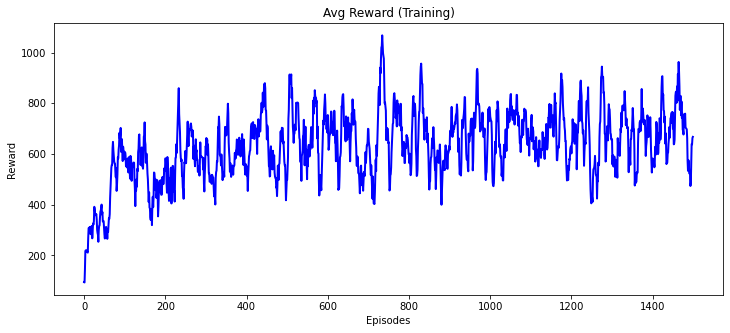

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(results, 'b', linewidth=2)
plt.title('Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

In [81]:
score, std = agent.evaluate(n_episodes=5)
print("score: ", score, " (", std , ")")

KeyboardInterrupt: 

## Exploit the policy

In [82]:
def show_policy(agent, env, steps=100):
    observation = env.reset()
    done = False
    for step in range(steps): 
        action = agent.eval_strategy.select_action(agent.target_model, observation)
        observation, reward, done, info = env.step(action)
        if done: 
            observation = env.reset()
        clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array') )
        plt.show()   
    return

In [83]:
show_policy(agent, env, steps=500)

KeyboardInterrupt: 